<a name="outline"></a>
# Predicting Visual Perception in Mice with Temporal Neuropixel Data

>   The goal of this project is to predict the visual stimulus presented to mice based on the firing network of the synapses between their neurons. We utilize data from the Ecephys Project, which employs Neuropixel technology to record large-scale neural activity. The neural activity, called action potentials, is the a electrical signal generated by the movement of charged ions across the membrane of a neuron. Each unique action potential can also be referred to as a unit. The following analysis includes creating a binned binary spike train dataset from the spike trains given by the Allen Institute, visualizing useful information, and applying deep learning as well as machine learning techniques for image prediction.

<a name="step0"></a>
## 0. Load Pre-Processed Data
*** Skip if data hasn't been processed. ***
- If one has already completed step 1, load the data here. 

[Go to Step 0](#step0content)

<a name="step1"></a>
## 1. Pull and Process Data
*** Skip if data is pre-processed. ***
- Pull data from the Ecephys repository and process it.
  - 1.1) Download and load necessary packages. \
  - 1.2) Create an instance on local computer. \
  - 1.3) Choose session.
  - 1.4) Filter invalid spike times and save data.
  - 1.5) Create spike train dataframe.
  - 1.6) Add the y value for each timestep.
  - 1.7) Save dataframe as pickle file.
    

[Go to Step 1](#step1content)

<a name="step2"></a>
## 2. Visualize the Data
- Here we will run visualizations to explain the information relevant to predicting visual perception with the data.
    - 2.1) 
    - 2.2) 
    - 2.3) 

[Go to Step 2](#step2content)

<a name="step3"></a>
## 3. Image Prediction Modeling
- Employ various machine learning 
and deep learning techniques to predict the visual stimulus given the data.

  - 3.1) Build test and train split.
  
  - 3.2) Baseline Model
  Our baseline model assumes a random guess, with an accuracy of 0.85% (1/117).

  - 3.3) Support Vector Machine with Radial Basis Function
    - We will use a Support Vector Machine with a Radial Basis Function as our first prediction model.

  - 3.4) Principal Component Regression.
   - Next, we will apply Principal Component Regression for image prediction.

  - 3.5)Train Neural Networks with different architectures.
   - Lastly, we will experiment with Neural Networks of varying architectures to optimize prediction accuracy.

  - 3.6) Build a Statitic Spatio-Temporal Graph Neural Network

[Go to Step 3](#step3content)


## References
[Go to References](#references)

*** Run the below cell to setup environment. 

In [6]:
# Setup Environment
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import psutil
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVR
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import torch
import seaborn as sns
import pickle
from torch_geometric.data import Data
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures

if torch.cuda.is_available():
    print("CUDA GPU is available.")
    device = torch.device('cuda')
else:
    print("CUDA GPU is not available. Using CPU instead.")
    device = torch.device('cpu')
    
print(f"Current GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
print(f"Total RAM: {(psutil.virtual_memory().total / (1024**3)):.2f} GB")
print(f"Available RAM: {(psutil.virtual_memory().available / (1024**3)):.2f} GB")

CUDA GPU is available.
Current GPU device: NVIDIA A100-PCIE-40GB MIG 2g.10gb
Total RAM: 1007.21 GB
Available RAM: 910.55 GB


<a name="step0content"></a>
## 0. Load Pre-Processed Data
[Go to Outline](#outline)

*** Skip if data hasn't been processed yet. *** \
Run step 0 to load the pre-processed data. Step 1 takes some processing time and it saves the processed data into files that can later be loaded through this step.

- 0.1) Set path to file in one's Google Drive.

- 0.2) Load the dataset and convert it to a pandas dataframe.

### 0.1) Set path to file in one's Google Drive.

In [6]:
# Path to pickle file in one's Google Drive.
pickle_file_path = '/content/drive/MyDrive/research/spike_trains_with_stimulus_session_721123822.pkl'

# Mount google drive.
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

### 0.2) Load the dataset.

In [2]:
# Load the dictionary of valid spike times from the pickle.
with open('spike_trains_with_stimulus_session_721123822.pkl', 'rb') as f:
    spike_df = pickle.load(f)
spike_df

950907203  950907205  950907518  950907524  950907209  950907207  \
0              0          2          0          0          0          0   
1              0          1          0          0          0          0   
2              0          0          0          0          0          0   
3              0          0          0          0          0          0   
4              0          1          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
59495          0          0          0          0          0          0   
59496          0          0          0          0          0          0   
59497          0          1          0          0          0          0   
59498          0          2          0          0          0          0   
59499          0          0          0          0          0          0   

       950907528  950907526  950907214  950907216  ...  950913428  950913495  \
0              0          0          0          0  ...          0          0   
1              0          1          0          0  ...          0          0   
2              0          0          0          0  ...          0          0   
3              0          0          0          0  ...          0          0   
4              0          1          1          0  ...          0          0   
...          ...        ...        ...        ...  ...        ...        ...   
59495          0          0          1          0  ...          0          0   
59496          0          0          1          0  ...          0          0   
59497          0          0          0          0  ...          0          0   
59498          0          0          0          0  ...          0          0   
59499          0          0          0          0  ...          0          0   

       950913484  950913475  950913466  950913839  950913553  950913542  \
0              0          0          0          0          1          0   
1              0          1          0          0          0          0   
2              0          1          0          0          0          0   
3              0          0          0          0          0          0   
4              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
59495          0          0          0          0          1          0   
59496          0          0          0          0          1          0   
59497          0          0          0          0          0          0   
59498          0          1          0          0          0          0   
59499          0          0          0          0          0          0   

       950913529  frame  
0              0   92.0  
1              0   92.0  
2              0   92.0  
3              0   92.0  
4              0   92.0  
...          ...    ...  
59495          0   17.0  
59496          0   17.0  
59497          0   17.0  
59498          0   17.0  
59499          0   17.0  

[59500 rows x 1192 columns]

### 0.3) Normalize Firing Rates.

In [17]:
### Clean the average firing rates by normalizing the data and removing outliers.
# The highest_value removes neurons who have a z score above that value.
# The lowest_value removes neurons whose z score never exceeds that value.
def clean_avg_firing_rates(df, highest_value, lowest_value):
    dfdataframe = df.copy()
    dfdataframe = dfdataframe.drop('frame', axis = 1)
    
    # Normalize the firing rates by calculating z-scores
    normalized_firing_rates = (dfdataframe.iloc[:, 1:] - dfdataframe.iloc[:, 1:].mean()) / dfdataframe.iloc[:, 1:].std()

    # Add the 'frame' column back to the normalized DataFrame
    normalized_firing_rates.insert(0, 'frame', df['frame'])

    # Identify the neurons that meet the given criteria
    selected_neurons_mask = (~(normalized_firing_rates.iloc[:, 1:] > highest_value).any(axis=0)) & ((normalized_firing_rates.iloc[:, 1:] > lowest_value).any(axis=0))

    # Filter the DataFrame based on the selected neurons
    filtered_normalized_firing_rates = normalized_firing_rates.loc[:, ['frame'] + selected_neurons_mask[selected_neurons_mask].index.tolist()]
    
    return filtered_normalized_firing_rates

# Use the function with the desired parameters
filtered_normalized_firing_rates = clean_avg_firing_rates(spike_df, highest_value=100, lowest_value=1)
filtered_normalized_firing_rates

frame  950907205  950907518  950907524  950907209  950907528  950907526  \
0      92.0   1.253388  -0.098398  -0.681226  -0.097059  -0.031769   4.108841   
1     114.0  -1.394929  -0.098398  -0.681226  -0.097059  -0.031769  -0.311265   
2     114.0  -0.865265  -0.098398  -0.681226  -0.097059  -0.031769   1.898788   
3       0.0  -0.865265  -0.098398   0.909549  -0.097059  -0.031769   4.108841   
4      37.0  -0.335602  -0.098398   0.909549  -0.097059  -0.031769   4.108841   
...     ...        ...        ...        ...        ...        ...        ...   
5945   15.0   0.194062  -0.098398  -0.681226  -0.097059  -0.031769  -0.311265   
5946   46.0  -0.865265  -0.098398   0.909549  -0.097059  -0.031769  -0.311265   
5947   86.0   0.194062  -0.098398   0.909549  -0.097059  -0.031769  -0.311265   
5948  110.0   1.253388  -0.098398  -0.681226  -0.097059  -0.031769  -0.311265   
5949   17.0   0.723725  -0.098398  -0.681226  -0.097059  -0.031769  -0.311265   

      950907214  950907216  950907211  ...  950913437  950913428  950913495  \
0     -0.522021  -1.042585  -0.074797  ...   1.087432  -0.340714   0.321338   
1     -0.522021  -1.042585  -0.074797  ...  -0.558516  -0.340714   0.857953   
2      0.243953  -1.042585  -0.074797  ...  -0.558516  -0.340714  -0.215278   
3      3.307852  -1.042585  -0.074797  ...  -0.558516  -0.340714  -0.751893   
4      0.243953   0.008123  12.640684  ...  -0.558516   0.565116  -0.215278   
...         ...        ...        ...  ...        ...        ...        ...   
5945   0.243953  -0.517231  -0.074797  ...   1.087432  -0.340714   1.394569   
5946  -0.522021  -1.042585  -0.074797  ...   0.264458  -0.340714   0.321338   
5947   0.243953   0.008123  -0.074797  ...   1.910406  -0.340714   0.321338   
5948   1.009928   1.058832  -0.074797  ...   1.087432  -0.340714  -0.751893   
5949  -0.522021  -1.042585  -0.074797  ...  -0.558516  -0.340714  -0.215278   

      950913484  950913475  950913466  950913839  950913553  950913542  \
0     -0.438852   0.834920  -0.531743  -0.172733  -0.556999  -0.508071   
1     -0.438852  -0.770436  -0.531743  -0.172733   0.990401  -0.508071   
2     -0.438852  -0.770436  -0.531743  -0.172733   0.603551  -0.508071   
3     -0.438852   0.032242   0.540393  -0.172733   0.603551   1.118083   
4      1.150418   0.032242  -0.531743  -0.172733  -0.943849  -0.508071   
...         ...        ...        ...        ...        ...        ...   
5945  -0.438852  -0.770436   2.684665  -0.172733  -0.170149  -0.508071   
5946  -0.438852  -0.770436  -0.531743  -0.172733   0.216701  -0.508071   
5947  -0.438852   0.032242  -0.531743  -0.172733   0.990401  -0.508071   
5948   1.150418   0.032242  -0.531743  -0.172733  -0.556999  -0.508071   
5949  -0.438852   0.834920  -0.531743  -0.172733   2.150952  -0.508071   

      950913529  
0     -0.298960  
1     -0.298960  
2     -0.298960  
3     -0.298960  
4     -0.298960  
...         ...  
5945  -0.298960  
5946  -0.298960  
5947  -0.298960  
5948   1.380747  
5949  -0.298960  

[5950 rows x 1172 columns]

In [18]:
# Save the dictionary of valid spike times to a pickle file
with open(f'spike_trains_with_stimulus_session_721123822.pkl', 'wb') as f:
    pickle.dump(filtered_normalized_firing_rates, f)

### 0.3) Or load Load filtered_normalized_firing_rates

In [3]:
filtered_normalized_pickle = 'filtered_normalized_pickle_721123822.pkl'

# Load the dictionary of valid spike times from the pickle.
with open(filtered_normalized_pickle, 'rb') as f:
    filtered_normalized_firing_rates = pickle.load(f)
filtered_normalized_firing_rates

frame  950907205  950907518  950907524  950907209  950907528  950907526  \
0      92.0   3.147226  -0.030984  -0.211255  -0.032035  -0.010042  -0.110522   
1      92.0   1.224244  -0.030984  -0.211255  -0.032035  -0.010042   7.736807   
2      92.0  -0.698737  -0.030984  -0.211255  -0.032035  -0.010042  -0.110522   
3      92.0  -0.698737  -0.030984  -0.211255  -0.032035  -0.010042  -0.110522   
4      92.0   1.224244  -0.030984  -0.211255  -0.032035  -0.010042   7.736807   
...     ...        ...        ...        ...        ...        ...        ...   
59495  17.0  -0.698737  -0.030984  -0.211255  -0.032035  -0.010042  -0.110522   
59496  17.0  -0.698737  -0.030984  -0.211255  -0.032035  -0.010042  -0.110522   
59497  17.0   1.224244  -0.030984  -0.211255  -0.032035  -0.010042  -0.110522   
59498  17.0   3.147226  -0.030984  -0.211255  -0.032035  -0.010042  -0.110522   
59499  17.0  -0.698737  -0.030984  -0.211255  -0.032035  -0.010042  -0.110522   

       950907214  950907216  950907211  ...  950913437  950913428  950913495  \
0      -0.560325  -0.468267   -0.02426  ...  -0.221451  -0.160645  -0.345801   
1      -0.560325  -0.468267   -0.02426  ...  -0.221451  -0.160645  -0.345801   
2      -0.560325  -0.468267   -0.02426  ...  -0.221451  -0.160645  -0.345801   
3      -0.560325  -0.468267   -0.02426  ...  -0.221451  -0.160645  -0.345801   
4       1.529261  -0.468267   -0.02426  ...  -0.221451  -0.160645  -0.345801   
...          ...        ...        ...  ...        ...        ...        ...   
59495   1.529261  -0.468267   -0.02426  ...  -0.221451  -0.160645  -0.345801   
59496   1.529261  -0.468267   -0.02426  ...  -0.221451  -0.160645  -0.345801   
59497  -0.560325  -0.468267   -0.02426  ...  -0.221451  -0.160645  -0.345801   
59498  -0.560325  -0.468267   -0.02426  ...  -0.221451  -0.160645  -0.345801   
59499  -0.560325  -0.468267   -0.02426  ...  -0.221451  -0.160645  -0.345801   

       950913484  950913475  950913466  950913839  950913553  950913542  \
0      -0.160753  -0.279658  -0.206547  -0.056136   1.177539  -0.211908   
1      -0.160753   2.633954  -0.206547  -0.056136  -0.617444  -0.211908   
2      -0.160753   2.633954  -0.206547  -0.056136  -0.617444  -0.211908   
3      -0.160753  -0.279658  -0.206547  -0.056136  -0.617444  -0.211908   
4      -0.160753  -0.279658  -0.206547  -0.056136  -0.617444  -0.211908   
...          ...        ...        ...        ...        ...        ...   
59495  -0.160753  -0.279658  -0.206547  -0.056136   1.177539  -0.211908   
59496  -0.160753  -0.279658  -0.206547  -0.056136   1.177539  -0.211908   
59497  -0.160753  -0.279658  -0.206547  -0.056136  -0.617444  -0.211908   
59498  -0.160753   2.633954  -0.206547  -0.056136  -0.617444  -0.211908   
59499  -0.160753  -0.279658  -0.206547  -0.056136  -0.617444  -0.211908   

       950913529  
0       -0.11824  
1       -0.11824  
2       -0.11824  
3       -0.11824  
4       -0.11824  
...          ...  
59495   -0.11824  
59496   -0.11824  
59497   -0.11824  
59498   -0.11824  
59499   -0.11824  

[59500 rows x 1142 columns]

<a name="step1content"></a>
## 1. Pull and Process Data
[Go to Outline](#outline)

*** Skip if data is pre-processed. *** \
The purpose of step one is to pull the necessary data for the project from the AllenSDK package, process the data, and save it.

- 1.1) Download and load necessary packages. 
- 1.2) Create an instance on local computer. 
- 1.3) Choose session an pull data.
- 1.4) Filter invalid spike times.
- 1.5) Bin the data. 
        -1.5.1) Bin the whole experiment.
        -1.5.2) Bin by frame in seconds.
        -1.5.3) Bin by frame in steps.
        -1.5.4) Bin by frame in steps and in parallel. 
- 1.6) create frame column.
- 1.7) Save dataframe as pickle file.
- 1.8) Normalize firing rates and save.

### 1.1) Download and load necessary packages.

In [42]:
# Load packages needed for step 1.
!pip install -q allensdk

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

### 1.2) Create an instance on local computer.

In [43]:
# Set output directory to a new folder called 'output' in the current working directory
output_dir = os.path.join(os.getcwd(), 'output')

# Check if the output directory exists, and create it if it doesn't
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set DOWNLOAD_COMPLETE_DATASET to True
DOWNLOAD_COMPLETE_DATASET = True

# Create a file path to the manifest.json file within the output directory
manifest_path = os.path.join(output_dir, "manifest.json")

# Check if the manifest.json file exists
if os.path.exists(manifest_path):
    print("Using existing manifest.json file.")
else:
    print("Creating a new manifest.json file.")

# Create an instance of the EcephysProjectCache class with the manifest file path as argument
cache = EcephysProjectCache(manifest=manifest_path)
# Get session table
session_table = cache.get_session_table()

# Display session keys
session_keys = []
print("Session keys:")
for session_key in session_table.index:
    session_keys.append(session_key)
print(session_keys)

Using existing manifest.json file.
Session keys:
[715093703, 719161530, 721123822, 732592105, 737581020, 739448407, 742951821, 743475441, 744228101, 746083955, 750332458, 750749662, 751348571, 754312389, 754829445, 755434585, 756029989, 757216464, 757970808, 758798717, 759883607, 760345702, 760693773, 761418226, 762120172, 762602078, 763673393, 766640955, 767871931, 768515987, 771160300, 771990200, 773418906, 774875821, 778240327, 778998620, 779839471, 781842082, 786091066, 787025148, 789848216, 791319847, 793224716, 794812542, 797828357, 798911424, 799864342, 816200189, 819186360, 819701982, 821695405, 829720705, 831882777, 835479236, 839068429, 839557629, 840012044, 847657808]


### 1.3) Choose session and pull data.

In [44]:
'''
 Pick session number
 '''
 
session_number = 721123822

In [45]:
# Pull session.
session = cache.get_session_data(session_number,
                                 isi_violations_maximum = np.inf,
                                 amplitude_cutoff_maximum = np.inf,
                                 presence_ratio_minimum = -np.inf
                                )
# Get spike times.
spike_times = session.spike_times
# Get specific stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# Display objects within session.
print("Session objects")
print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])

Session objects
['DETAILED_STIMULUS_PARAMETERS', 'LazyProperty', 'age_in_days', 'api', 'channel_structure_intervals', 'channels', 'conditionwise_spike_statistics', 'ecephys_session_id', 'from_nwb_path', 'full_genotype', 'get_current_source_density', 'get_inter_presentation_intervals_for_stimulus', 'get_invalid_times', 'get_lfp', 'get_parameter_values_for_stimulus', 'get_pupil_data', 'get_screen_gaze_data', 'get_stimulus_epochs', 'get_stimulus_parameter_values', 'get_stimulus_table', 'inter_presentation_intervals', 'invalid_times', 'mean_waveforms', 'metadata', 'num_channels', 'num_probes', 'num_stimulus_presentations', 'num_units', 'optogenetic_stimulation_epochs', 'presentationwise_spike_counts', 'presentationwise_spike_times', 'probes', 'rig_equipment_name', 'rig_geometry_data', 'running_speed', 'session_start_time', 'session_type', 'sex', 'specimen_name', 'spike_amplitudes', 'spike_times', 'stimulus_conditions', 'stimulus_names', 'stimulus_presentations', 'structure_acronyms', 'stru

### 1.4) Filter invalid spike times.

In [46]:
# Access the invalid_times DataFrame
invalid_times = session.invalid_times

# Function to check if a spike time is valid
def is_valid_time(spike_times, invalid_intervals):
    invalid = np.zeros_like(spike_times, dtype=bool)
    for _, row in invalid_intervals.iterrows():
        start, end = row['start_time'], row['stop_time']
        invalid |= (spike_times >= start) & (spike_times <= end)
    return ~invalid

# Filter the valid spike times
valid_spike_times = {}
with tqdm(total=len(spike_times), desc='Filtering valid spike times') as pbar:
    for neuron, times in spike_times.items():
        valid_mask = is_valid_time(times, session.invalid_times)
        valid_spike_times[neuron] = times[valid_mask]
        pbar.update(1)

Filtering valid spike times: 100%|██████████| 1191/1191 [00:00<00:00, 1953.22it/s]


### 1.5) Bin the data.

#### 1.5.1) Bin the whole experiment. 
With respect to time.

In [ ]:
'''
Set the bin_size below.

A "bin_size = .01" will create a 10 millisecond per timestep dataframe.
While a "bin_size = 1" will create a 1 second per timestep dataframe.
'''
bin_size = .025

### Bin the data based on the bin_size.

# Where each column is a unique neuron and each row is a binned timeframe.
spike_times = valid_spike_times
# Parameters
num_neurons = len(spike_times.keys())

# Find the maximum time across all neurons
max_time = max([max(times) for times in spike_times.values() if len(times) > 0])

# Calculate the number of bins
num_bins = int(np.ceil(max_time / bin_size))

# Create an empty binary spike matrix
spike_matrix = np.zeros((num_neurons, num_bins), dtype=np.int32)

# Bin the spike times and fill the spike_matrix
with tqdm(total=num_neurons, desc='Processing neurons') as pbar:
    for neuron_idx, times in enumerate(spike_times.values()):

        # Convert spike times to bin indices
        bin_indices = (times // bin_size).astype(int)

        # Update the corresponding bins
        for bin_index in bin_indices:
            spike_matrix[neuron_idx, bin_index] += 1

        pbar.update(1)

# Convert the spike matrix to a pandas DataFrame and set the index to neuron IDs
spike_dataframe = pd.DataFrame(spike_matrix, index=spike_times.keys())

spike_dataframe.T

#### 1.5.2) Bin with respect to each frame by seconds.

In [ ]:
# Parameters
bin_size = 0.025  # Set bin size (in seconds)

stimulus_table = session.get_stimulus_table("natural_scenes")

# The start times of each stimulus presentation
image_start_times = stimulus_table.start_time.values

# The end times of each stimulus presentation
image_end_times = stimulus_table.stop_time.values  

# The number of bins per image presentation
bins_per_image = np.ceil((image_end_times - image_start_times) / bin_size).astype(int)

# The total number of bins
total_bins = bins_per_image.sum()

# Create an empty binary spike matrix
num_neurons = len(spike_times.keys())
spike_matrix = np.zeros((num_neurons, total_bins), dtype=np.int32)

with tqdm(total=num_neurons, desc='Processing neurons') as pbar:
    for neuron_idx, times in enumerate(spike_times.values()):
        # The start bin for the next image presentation
        start_bin = 0  # Move this line inside the loop over neuron_idx
        
        
        for image_idx, (start_time, end_time) in enumerate(zip(image_start_times, image_end_times)):
            print(times)
            # Bin edges for this image presentation
            bin_edges = np.linspace(start_time, end_time, bins_per_image[image_idx] + 1)

            # Bin the spike times for this image presentation
            binned_spike_times = np.histogram(times, bins=bin_edges)[0]

            # Add the binned spike times to the spike matrix
            end_bin = start_bin + bins_per_image[image_idx]
            if len(binned_spike_times) == len(spike_matrix[neuron_idx, start_bin:end_bin]):
                spike_matrix[neuron_idx, start_bin:end_bin] = binned_spike_times

            # Update the start bin for the next image presentation
            start_bin = end_bin

        pbar.update(1)

# Convert the spike matrix to a pandas DataFrame and set the index to neuron IDs
spike_dataframe = pd.DataFrame(spike_matrix, index=spike_times.keys())

spike_dataframe.T

Processing neurons: 100%|██████████| 1191/1191 [1:35:43<00:00,  4.82s/it]


950907203  950907205  950907518  950907524  950907209  950907207  \
0              0          2          0          0          0          0   
1              0          1          0          0          0          0   
2              0          0          0          0          0          0   
3              0          0          0          0          0          0   
4              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
65446          0          0          0          0          0          0   
65447          0          0          0          0          0          0   
65448          0          1          0          0          0          0   
65449          0          2          0          0          0          0   
65450          0          0          0          0          0          0   

       950907528  950907526  950907214  950907216  ...  950913437  950913428  \
0              0          0          0          0  ...          0          0   
1              0          1          0          0  ...          0          0   
2              0          0          0          0  ...          0          0   
3              0          0          0          0  ...          0          0   
4              0          1          0          0  ...          0          0   
...          ...        ...        ...        ...  ...        ...        ...   
65446          0          0          1          0  ...          0          0   
65447          0          0          0          0  ...          0          0   
65448          0          0          0          0  ...          0          0   
65449          0          0          0          0  ...          0          0   
65450          0          0          0          0  ...          0          0   

       950913495  950913484  950913475  950913466  950913839  950913553  \
0              0          0          0          0          0          1   
1              0          0          1          0          0          0   
2              0          0          1          0          0          0   
3              0          0          0          0          0          0   
4              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
65446          0          0          0          0          0          1   
65447          0          0          0          0          0          1   
65448          0          0          0          0          0          0   
65449          0          0          1          0          0          0   
65450          0          0          0          0          0          0   

       950913542  950913529  
0              0          0  
1              0          0  
2              0          0  
3              0          0  
4              0          0  
...          ...        ...  
65446          0          0  
65447          0          0  
65448          0          0  
65449          0          0  
65450          0          0  

[65451 rows x 1191 columns]

#### 1.5.3) Bin with respect to each frame by steps.

In [8]:
# Parameters
timesteps_per_frame = 10  # Set the number of timesteps per frame

# Stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# The start times of each stimulus presentation
image_start_times = torch.tensor(stimulus_table.start_time.values)

# The end times of each stimulus presentation
image_end_times = torch.tensor(stimulus_table.stop_time.values)

# The duration of each image presentation
image_durations = image_end_times - image_start_times

# The bin size for each image presentation
bin_sizes = image_durations / timesteps_per_frame

# The number of bins per image presentation
bins_per_image = timesteps_per_frame

# The total number of bins
total_bins = bins_per_image * len(image_start_times)

# Create an empty binary spike matrix
num_neurons = len(spike_times.keys())
spike_matrix = torch.zeros((num_neurons, total_bins), dtype=torch.int32)

with tqdm(total=num_neurons, desc='Processing neurons') as pbar:
    for neuron_idx, times in enumerate(spike_times.values()):
        # The start bin for the next image presentation
        start_bin = 0  # Move this line inside the loop over neuron_idx
        for image_idx, (start_time, end_time) in enumerate(zip(image_start_times, image_end_times)):
            # Bin edges for this image presentation
            bin_edges = torch.linspace(start_time, end_time, bins_per_image + 1)

            # Bin the spike times for this image presentation
            binned_spike_times = torch.histc(torch.tensor(times), bins=bin_edges.shape[0]-1, min=bin_edges.min(), max=bin_edges.max())

            # Add the binned spike times to the spike matrix
            end_bin = start_bin + bins_per_image
            if len(binned_spike_times) == len(spike_matrix[neuron_idx, start_bin:end_bin]):
                spike_matrix[neuron_idx, start_bin:end_bin] = binned_spike_times

            # Update the start bin for the next image presentation
            start_bin = end_bin

        pbar.update(1)

# Convert the spike matrix to a pandas DataFrame and set the index to neuron IDs
spike_dataframe = pd.DataFrame(spike_matrix.numpy(), index=spike_times.keys())

spike_dataframe.T

Processing neurons: 100%|██████████| 1191/1191 [17:53<00:00,  1.11it/s]


950907203  950907205  950907518  950907524  950907209  950907207  \
0              0          2          0          0          0          0   
1              0          1          0          0          0          0   
2              0          0          0          0          0          0   
3              0          0          0          0          0          0   
4              0          1          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
59495          0          0          0          0          0          0   
59496          0          0          0          0          0          0   
59497          0          1          0          0          0          0   
59498          0          2          0          0          0          0   
59499          0          0          0          0          0          0   

       950907528  950907526  950907214  950907216  ...  950913437  950913428  \
0              0          0          0          0  ...          0          0   
1              0          1          0          0  ...          0          0   
2              0          0          0          0  ...          0          0   
3              0          0          0          0  ...          0          0   
4              0          1          1          0  ...          0          0   
...          ...        ...        ...        ...  ...        ...        ...   
59495          0          0          1          0  ...          0          0   
59496          0          0          1          0  ...          0          0   
59497          0          0          0          0  ...          0          0   
59498          0          0          0          0  ...          0          0   
59499          0          0          0          0  ...          0          0   

       950913495  950913484  950913475  950913466  950913839  950913553  \
0              0          0          0          0          0          1   
1              0          0          1          0          0          0   
2              0          0          1          0          0          0   
3              0          0          0          0          0          0   
4              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
59495          0          0          0          0          0          1   
59496          0          0          0          0          0          1   
59497          0          0          0          0          0          0   
59498          0          0          1          0          0          0   
59499          0          0          0          0          0          0   

       950913542  950913529  
0              0          0  
1              0          0  
2              0          0  
3              0          0  
4              0          0  
...          ...        ...  
59495          0          0  
59496          0          0  
59497          0          0  
59498          0          0  
59499          0          0  

[59500 rows x 1191 columns]

#### 1.5.4) Split by frame and in parallel. 

In [71]:
import concurrent.futures

# Parameters
timesteps_per_frame = 10  # Set the number of timesteps per frame

# Stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# The start times of each stimulus presentation
image_start_times = torch.tensor(stimulus_table.start_time.values)

# The end times of each stimulus presentation
image_end_times = torch.tensor(stimulus_table.stop_time.values)

# The duration of each image presentation
image_durations = image_end_times - image_start_times

# The bin size for each image presentation
bin_sizes = image_durations / timesteps_per_frame

# The number of bins per image presentation
bins_per_image = timesteps_per_frame

# The total number of bins
total_bins = bins_per_image * len(image_start_times)

# Create an empty binary spike matrix
num_neurons = len(spike_times.keys())

def process_neuron(times):
    # The start bin for the next image presentation
    start_bin = 0
    neuron_spike_bins = torch.zeros(total_bins, dtype=torch.int32)
    for image_idx, (start_time, end_time) in enumerate(zip(image_start_times, image_end_times)):
        # Bin edges for this image presentation
        bin_edges = torch.linspace(start_time, end_time, bins_per_image + 1)

        # Bin the spike times for this image presentation
        binned_spike_times = torch.histc(torch.tensor(times), bins=bin_edges.shape[0]-1, min=bin_edges.min(), max=bin_edges.max())

        # Add the binned spike times to the spike matrix
        end_bin = start_bin + bins_per_image
        if len(binned_spike_times) == len(neuron_spike_bins[start_bin:end_bin]):
            neuron_spike_bins[start_bin:end_bin] = binned_spike_times

        # Update the start bin for the next image presentation
        start_bin = end_bin
    return neuron_spike_bins

with concurrent.futures.ProcessPoolExecutor() as executor:
    spike_matrix = list(tqdm(executor.map(process_neuron, spike_times.values()), total=num_neurons, desc='Processing neurons'))

spike_matrix = torch.stack(spike_matrix)

# Convert the spike matrix to a pandas DataFrame and set the index to neuron IDs
spike_dataframe = pd.DataFrame(spike_matrix.numpy(), index=spike_times.keys())

spike_dataframe.T

Processing neurons: 100%|██████████| 1191/1191 [03:41<00:00,  5.37it/s]


950907203  950907205  950907518  950907524  950907209  950907207  \
0              0          2          0          0          0          0   
1              0          1          0          0          0          0   
2              0          0          0          0          0          0   
3              0          0          0          0          0          0   
4              0          1          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
59495          0          0          0          0          0          0   
59496          0          0          0          0          0          0   
59497          0          1          0          0          0          0   
59498          0          2          0          0          0          0   
59499          0          0          0          0          0          0   

       950907528  950907526  950907214  950907216  ...  950913437  950913428  \
0              0          0          0          0  ...          0          0   
1              0          1          0          0  ...          0          0   
2              0          0          0          0  ...          0          0   
3              0          0          0          0  ...          0          0   
4              0          1          1          0  ...          0          0   
...          ...        ...        ...        ...  ...        ...        ...   
59495          0          0          1          0  ...          0          0   
59496          0          0          1          0  ...          0          0   
59497          0          0          0          0  ...          0          0   
59498          0          0          0          0  ...          0          0   
59499          0          0          0          0  ...          0          0   

       950913495  950913484  950913475  950913466  950913839  950913553  \
0              0          0          0          0          0          1   
1              0          0          1          0          0          0   
2              0          0          1          0          0          0   
3              0          0          0          0          0          0   
4              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
59495          0          0          0          0          0          1   
59496          0          0          0          0          0          1   
59497          0          0          0          0          0          0   
59498          0          0          1          0          0          0   
59499          0          0          0          0          0          0   

       950913542  950913529  
0              0          0  
1              0          0  
2              0          0  
3              0          0  
4              0          0  
...          ...        ...  
59495          0          0  
59496          0          0  
59497          0          0  
59498          0          0  
59499          0          0  

[59500 rows x 1191 columns]

### 1.6) Create frame column.

In [51]:
spike_df = spike_dataframe.T
spike_df['frame'] = 'nan'
spike_df['frame'] = np.repeat(np.array(stimulus_table['frame']), 10)

spike_df

950907203  950907205  950907518  950907524  950907209  950907207  \
0              0          2          0          0          0          0   
1              0          1          0          0          0          0   
2              0          0          0          0          0          0   
3              0          0          0          0          0          0   
4              0          1          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
59495          0          0          0          0          0          0   
59496          0          0          0          0          0          0   
59497          0          1          0          0          0          0   
59498          0          2          0          0          0          0   
59499          0          0          0          0          0          0   

       950907528  950907526  950907214  950907216  ...  950913428  950913495  \
0              0          0          0          0  ...          0          0   
1              0          1          0          0  ...          0          0   
2              0          0          0          0  ...          0          0   
3              0          0          0          0  ...          0          0   
4              0          1          1          0  ...          0          0   
...          ...        ...        ...        ...  ...        ...        ...   
59495          0          0          1          0  ...          0          0   
59496          0          0          1          0  ...          0          0   
59497          0          0          0          0  ...          0          0   
59498          0          0          0          0  ...          0          0   
59499          0          0          0          0  ...          0          0   

       950913484  950913475  950913466  950913839  950913553  950913542  \
0              0          0          0          0          1          0   
1              0          1          0          0          0          0   
2              0          1          0          0          0          0   
3              0          0          0          0          0          0   
4              0          0          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
59495          0          0          0          0          1          0   
59496          0          0          0          0          1          0   
59497          0          0          0          0          0          0   
59498          0          1          0          0          0          0   
59499          0          0          0          0          0          0   

       950913529  frame  
0              0   92.0  
1              0   92.0  
2              0   92.0  
3              0   92.0  
4              0   92.0  
...          ...    ...  
59495          0   17.0  
59496          0   17.0  
59497          0   17.0  
59498          0   17.0  
59499          0   17.0  

[59500 rows x 1192 columns]

In [52]:
# Assuming you have a DataFrame called 'spike_df'
nan_count = spike_df.isna().sum().sum()

print(f"Number of NaN values: {nan_count}")

Number of NaN values: 0


In [53]:
pd.unique(spike_df.iloc[:,6].values)

array([0, 1], dtype=int32)

### 1.7) Save dataframe as pickle file.

In [54]:
# Save the dictionary of valid spike times to a pickle file
with open(f'spike_trains_with_stimulus_session_{session_number}.pkl', 'wb') as f:
    pickle.dump(spike_df, f)

### 1.8) Normalize Firing Rates.

In [ ]:
### Clean the average firing rates by normalizing the data and removing outliers.
# The highest_value removes neurons who have a z score above that value.
# The lowest_value removes neurons whose z score never exceeds that value.
def clean_avg_firing_rates(df, highest_value, lowest_value):
    dfdataframe = df.copy()
    dfdataframe = dfdataframe.drop('frame', axis = 1)
    
    # Normalize the firing rates by calculating z-scores
    normalized_firing_rates = (dfdataframe.iloc[:, 1:] - dfdataframe.iloc[:, 1:].mean()) / dfdataframe.iloc[:, 1:].std()

    # Add the 'frame' column back to the normalized DataFrame
    normalized_firing_rates.insert(0, 'frame', df['frame'])

    # Identify the neurons that meet the given criteria
    selected_neurons_mask = (~(normalized_firing_rates.iloc[:, 1:] > highest_value).any(axis=0)) & ((normalized_firing_rates.iloc[:, 1:] > lowest_value).any(axis=0))

    # Filter the DataFrame based on the selected neurons
    filtered_normalized_firing_rates = normalized_firing_rates.loc[:, ['frame'] + selected_neurons_mask[selected_neurons_mask].index.tolist()]
    
    return filtered_normalized_firing_rates

# Use the function with the desired parameters
filtered_normalized_firing_rates = clean_avg_firing_rates(spike_df, highest_value=100, lowest_value=1)

# Check if there are any NaN values
if filtered_normalized_firing_rates.isna().any().any():
    print("There are NaN values in the DataFrame")
else:
    print("There are no NaN values in the DataFrame")
    
filtered_normalized_firing_rates

### 1.9) Save the Filtered and normalized dataset.

In [ ]:
# Save the dictionary of valid spike times to a pickle file
with open(f'filtered_normalized_pickle_{session_number}.pkl', 'wb') as f:
    pickle.dump(filtered_normalized_firing_rates, f)

<a name="step2content"></a>
## 2. Visualize the Data
[Go to Outline](#outline)

Here we will look at different aspects of the data we are concerned with. 

- 2.0) *** Set up environment for visualizations below. ***
- 2.1) Visual stimulus presented. 
- 2.2) Visualize the unique firing pattern of different units.  
- 2.3) Raster plot of the spike trains for each neuron. 
- 2.4) Sorted correlation matrix between Units
- 2.5) Grouped Heat Maps of Unit Resposes by Frames

### 2.0) *** Set up environment for visualizations below. ***

*** To set up the environment. *** \
1st, run 2.0.1. \
2nd, run 2.0.2 if one hasn't already calculated the average firing rate per frame. If they haven't been calculated, run 2.0.3 to load them in.

#### 2.0.1) Run Cell to set up environment for visualizations.

In [38]:
# Load packages needed for step 1.
!pip install -q allensdk

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# Define Carolina blue color (in RGB format)
carolina_blue = (86/255, 160/255, 211/255)

# Set output directory to a new folder called 'output' in the current working directory
output_dir = os.path.join(os.getcwd(), 'output')

# Check if the output directory exists, and create it if it doesn't
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set DOWNLOAD_COMPLETE_DATASET to True
DOWNLOAD_COMPLETE_DATASET = True

# Create a file path to the manifest.json file within the output directory
manifest_path = os.path.join(output_dir, "manifest.json")

# Check if the manifest.json file exists
if os.path.exists(manifest_path):
    print("Using existing manifest.json file.")
else:
    print("Creating a new manifest.json file.")

# Create an instance of the EcephysProjectCache class with the manifest file path as argument
cache = EcephysProjectCache(manifest=manifest_path)
# Get session table
session_table = cache.get_session_table()

'''
 Pick session number
 '''
 
session_number = 721123822

# Pull session.
session = cache.get_session_data(session_number,
                                 isi_violations_maximum = np.inf,
                                 amplitude_cutoff_maximum = np.inf,
                                 presence_ratio_minimum = -np.inf
                                )
# Get spike times.
spike_times = session.spike_times
# Get specific stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# Display objects within session.
print("Session objects")
print([attr_or_method for attr_or_method in dir(session) if attr_or_method[0] != '_'])

Using existing manifest.json file.
Session objects
['DETAILED_STIMULUS_PARAMETERS', 'LazyProperty', 'age_in_days', 'api', 'channel_structure_intervals', 'channels', 'conditionwise_spike_statistics', 'ecephys_session_id', 'from_nwb_path', 'full_genotype', 'get_current_source_density', 'get_inter_presentation_intervals_for_stimulus', 'get_invalid_times', 'get_lfp', 'get_parameter_values_for_stimulus', 'get_pupil_data', 'get_screen_gaze_data', 'get_stimulus_epochs', 'get_stimulus_parameter_values', 'get_stimulus_table', 'inter_presentation_intervals', 'invalid_times', 'mean_waveforms', 'metadata', 'num_channels', 'num_probes', 'num_stimulus_presentations', 'num_units', 'optogenetic_stimulation_epochs', 'presentationwise_spike_counts', 'presentationwise_spike_times', 'probes', 'rig_equipment_name', 'rig_geometry_data', 'running_speed', 'session_start_time', 'session_type', 'sex', 'specimen_name', 'spike_amplitudes', 'spike_times', 'stimulus_conditions', 'stimulus_names', 'stimulus_presenta

#### 2.0.2) Calulate the firing rates per frame, average firing rate per image, and average firing rate per second.

Calculate the average firing rate per frame. 

In [7]:
# Parameters
timesteps_per_frame = 1  # Set the number of timesteps per frame

# Stimulus table.
stimulus_table = session.get_stimulus_table("natural_scenes")

# The start times of each stimulus presentation
image_start_times = torch.tensor(stimulus_table.start_time.values)

# The end times of each stimulus presentation
image_end_times = torch.tensor(stimulus_table.stop_time.values)

# The duration of each image presentation
image_durations = image_end_times - image_start_times

# The bin size for each image presentation
bin_sizes = image_durations / timesteps_per_frame

# The number of bins per image presentation
bins_per_image = timesteps_per_frame

# The total number of bins
total_bins = bins_per_image * len(image_start_times)

# Create an empty binary spike matrix
num_neurons = len(spike_times.keys())

def process_neuron(times):
    # The start bin for the next image presentation
    start_bin = 0
    neuron_spike_bins = torch.zeros(total_bins, dtype=torch.int32)
    for image_idx, (start_time, end_time) in enumerate(zip(image_start_times, image_end_times)):
        # Bin edges for this image presentation
        bin_edges = torch.linspace(start_time, end_time, bins_per_image + 1)

        # Bin the spike times for this image presentation
        binned_spike_times = torch.histc(torch.tensor(times), bins=bin_edges.shape[0]-1, min=bin_edges.min(), max=bin_edges.max())

        # Add the binned spike times to the spike matrix
        end_bin = start_bin + bins_per_image
        if len(binned_spike_times) == len(neuron_spike_bins[start_bin:end_bin]):
            neuron_spike_bins[start_bin:end_bin] = binned_spike_times

        # Update the start bin for the next image presentation
        start_bin = end_bin
    return neuron_spike_bins

with concurrent.futures.ProcessPoolExecutor() as executor:
    spike_matrix = list(tqdm(executor.map(process_neuron, spike_times.values()), total=num_neurons, desc='Processing neurons'))

spike_matrix = torch.stack(spike_matrix)

# Convert the spike matrix to a pandas DataFrame and set the index to neuron IDs
spike_dataframe = pd.DataFrame(spike_matrix.numpy(), index=spike_times.keys())

spikes_per_frame = spike_dataframe.T
spikes_per_frame['frame'] = 'nan'
spikes_per_frame['frame'] = np.array(stimulus_table['frame'])
spikes_per_frame

Processing neurons: 100%|██████████| 1191/1191 [02:19<00:00,  8.56it/s]


950907203  950907205  950907518  950907524  950907209  950907207  \
0             0          6          0          0          0          0   
1             1          1          0          0          0          0   
2             0          2          0          0          0          0   
3             1          2          0          1          0          0   
4             1          3          0          1          0          0   
...         ...        ...        ...        ...        ...        ...   
5945          1          4          0          0          0          0   
5946          2          2          0          1          0          0   
5947          1          4          0          1          0          0   
5948          1          6          0          0          0          0   
5949          1          5          0          0          0          0   

      950907528  950907526  950907214  950907216  ...  950913428  950913495  \
0             0          2          2          0  ...          0          2   
1             0          0          2          0  ...          0          3   
2             0          1          3          0  ...          0          1   
3             0          2          7          0  ...          0          0   
4             0          2          3          2  ...          1          1   
...         ...        ...        ...        ...  ...        ...        ...   
5945          0          0          3          1  ...          0          4   
5946          0          0          2          0  ...          0          2   
5947          0          0          3          2  ...          0          2   
5948          0          0          4          4  ...          0          0   
5949          0          0          2          0  ...          0          1   

      950913484  950913475  950913466  950913839  950913553  950913542  \
0             0          2          0          0          2          0   
1             0          0          0          0          6          0   
2             0          0          0          0          5          0   
3             0          1          1          0          5          2   
4             1          1          0          0          1          0   
...         ...        ...        ...        ...        ...        ...   
5945          0          0          3          0          3          0   
5946          0          0          0          0          4          0   
5947          0          1          0          0          6          0   
5948          1          1          0          0          2          0   
5949          0          2          0          0          9          0   

      950913529  frame  
0             0   92.0  
1             0  114.0  
2             0  114.0  
3             0    0.0  
4             0   37.0  
...         ...    ...  
5945          0   15.0  
5946          0   46.0  
5947          0   86.0  
5948          1  110.0  
5949          0   17.0  

[5950 rows x 1192 columns]

Calculate spikes per image by taking the average of the spikes_per_frame calculation.

In [26]:
spikes_per_image = spikes_per_frame.groupby('frame').mean().iloc[1:,1:]
spikes_per_image.reset_index(inplace=True)
spikes_per_image

frame  950907205  950907518  950907524  950907209  950907207  950907528  \
0      0.0       3.66       0.04       0.46       0.02        0.0        0.0   
1      1.0       3.70       0.02       0.32       0.00        0.0        0.0   
2      2.0       3.38       0.00       0.42       0.00        0.0        0.0   
3      3.0       3.74       0.02       0.46       0.02        0.0        0.0   
4      4.0       3.68       0.00       0.42       0.00        0.0        0.0   
..     ...        ...        ...        ...        ...        ...        ...   
113  113.0       3.48       0.00       0.56       0.02        0.0        0.0   
114  114.0       3.32       0.02       0.30       0.00        0.0        0.0   
115  115.0       3.56       0.02       0.40       0.02        0.0        0.0   
116  116.0       3.58       0.02       0.48       0.00        0.0        0.0   
117  117.0       3.68       0.02       0.46       0.00        0.0        0.0   

     950907526  950907214  950907216  ...  950913437  950913428  950913495  \
0         0.16       2.74       2.34  ...       0.94       0.20       1.40   
1         0.12       2.70       1.78  ...       0.72       0.40       2.74   
2         0.08       2.82       2.26  ...       0.68       3.94       3.42   
3         0.14       2.64       1.78  ...       1.16       0.60       2.48   
4         0.12       2.82       2.12  ...       0.76       0.14       0.56   
..         ...        ...        ...  ...        ...        ...        ...   
113       0.16       2.66       1.84  ...       0.82       0.22       3.44   
114       0.08       2.82       2.24  ...       0.34       1.06       2.06   
115       0.10       2.54       1.94  ...       0.32       0.56       1.72   
116       0.14       2.20       2.00  ...       0.96       0.26       0.72   
117       0.14       2.52       1.60  ...       0.34       0.02       0.80   

     950913484  950913475  950913466  950913839  950913553  950913542  \
0         0.54       1.38       0.78       0.18       4.22       3.04   
1         0.46       1.28       0.56       0.08       2.70       2.46   
2         0.92       2.12       1.36       0.12       4.22       1.58   
3         0.50       1.44       1.06       0.06       3.08       1.00   
4         0.34       1.06       0.34       0.04       2.78       1.02   
..         ...        ...        ...        ...        ...        ...   
113       0.28       1.00       0.60       0.02       3.34       1.18   
114       0.26       1.18       0.54       0.00       4.20       0.18   
115       0.24       1.52       0.56       0.00       4.86       0.30   
116       0.62       0.92       0.22       0.06       3.34       2.34   
117       0.18       0.94       0.70       0.02       3.80       0.16   

     950913529  
0         0.18  
1         0.16  
2         0.76  
3         0.46  
4         0.24  
..         ...  
113       0.42  
114       0.20  
115       1.06  
116       0.10  
117       0.04  

[118 rows x 1191 columns]

Estimate the average spikes per second or firing rate in Hertz by multiplying spikes_per_image by 4. Each frame is roughly a quarter second. One can compute the actual average but that is much more computationally intensive(over 7500 times more intesnive). 

In [30]:
firing_rate_hz = spikes_per_image * 4
firing_rate_hz['frame'] = spikes_per_image['frame']
firing_rate_hz

frame  950907205  950907518  950907524  950907209  950907207  950907528  \
0      0.0      14.64       0.16       1.84       0.08        0.0        0.0   
1      1.0      14.80       0.08       1.28       0.00        0.0        0.0   
2      2.0      13.52       0.00       1.68       0.00        0.0        0.0   
3      3.0      14.96       0.08       1.84       0.08        0.0        0.0   
4      4.0      14.72       0.00       1.68       0.00        0.0        0.0   
..     ...        ...        ...        ...        ...        ...        ...   
113  113.0      13.92       0.00       2.24       0.08        0.0        0.0   
114  114.0      13.28       0.08       1.20       0.00        0.0        0.0   
115  115.0      14.24       0.08       1.60       0.08        0.0        0.0   
116  116.0      14.32       0.08       1.92       0.00        0.0        0.0   
117  117.0      14.72       0.08       1.84       0.00        0.0        0.0   

     950907526  950907214  950907216  ...  950913437  950913428  950913495  \
0         0.64      10.96       9.36  ...       3.76       0.80       5.60   
1         0.48      10.80       7.12  ...       2.88       1.60      10.96   
2         0.32      11.28       9.04  ...       2.72      15.76      13.68   
3         0.56      10.56       7.12  ...       4.64       2.40       9.92   
4         0.48      11.28       8.48  ...       3.04       0.56       2.24   
..         ...        ...        ...  ...        ...        ...        ...   
113       0.64      10.64       7.36  ...       3.28       0.88      13.76   
114       0.32      11.28       8.96  ...       1.36       4.24       8.24   
115       0.40      10.16       7.76  ...       1.28       2.24       6.88   
116       0.56       8.80       8.00  ...       3.84       1.04       2.88   
117       0.56      10.08       6.40  ...       1.36       0.08       3.20   

     950913484  950913475  950913466  950913839  950913553  950913542  \
0         2.16       5.52       3.12       0.72      16.88      12.16   
1         1.84       5.12       2.24       0.32      10.80       9.84   
2         3.68       8.48       5.44       0.48      16.88       6.32   
3         2.00       5.76       4.24       0.24      12.32       4.00   
4         1.36       4.24       1.36       0.16      11.12       4.08   
..         ...        ...        ...        ...        ...        ...   
113       1.12       4.00       2.40       0.08      13.36       4.72   
114       1.04       4.72       2.16       0.00      16.80       0.72   
115       0.96       6.08       2.24       0.00      19.44       1.20   
116       2.48       3.68       0.88       0.24      13.36       9.36   
117       0.72       3.76       2.80       0.08      15.20       0.64   

     950913529  
0         0.72  
1         0.64  
2         3.04  
3         1.84  
4         0.96  
..         ...  
113       1.68  
114       0.80  
115       4.24  
116       0.40  
117       0.16  

[118 rows x 1191 columns]

Save them all

In [33]:
# Save the dictionary of valid spike times to a pickle file
with open(f'spikes_per_frame_{session_number}.pkl', 'wb') as f:
    pickle.dump(spikes_per_frame, f)
    
# Save the dictionary of valid spike times to a pickle file
with open(f'spikes_per_image_{session_number}.pkl', 'wb') as f:
    pickle.dump(spikes_per_image, f)

# Save the dictionary of valid spike times to a pickle file
with open(f'firing_rate_hz_{session_number}.pkl', 'wb') as f:
    pickle.dump(firing_rate_hz, f)

#### 2.0.3) Load the firing rates per frame, average firing rate per image, and average firing rate per second.

In [37]:
spikes_per_frame = 'spikes_per_frame_721123822.pkl'
spikes_per_image = 'spikes_per_image_721123822.pkl'
firing_rate_hz = 'firing_rate_hz_721123822.pkl'

# Load the dictionary of valid spike times from the pickle.
with open(spikes_per_frame, 'rb') as f:
    spikes_per_frame = pickle.load(f)

# Load the dictionary of valid spike times from the pickle.
with open(spikes_per_image, 'rb') as f:
    spikes_per_image = pickle.load(f)

# Load the dictionary of valid spike times from the pickle.
with open(firing_rate_hz, 'rb') as f:
    firing_rate_hz = pickle.load(f)
    
print(np.shape(spikes_per_frame))
print(np.shape(spikes_per_image))
print(np.shape(firing_rate_hz))

(5950, 1192)
(118, 1191)
(118, 1191)


### 2.1) Visual stimulus presented. 

In this experiment mice were shown 118 different images of natural scenes around 50 times per image. These images are the events we are trying to predict given the firing rate of each unit.

- Below are all of the images shown.

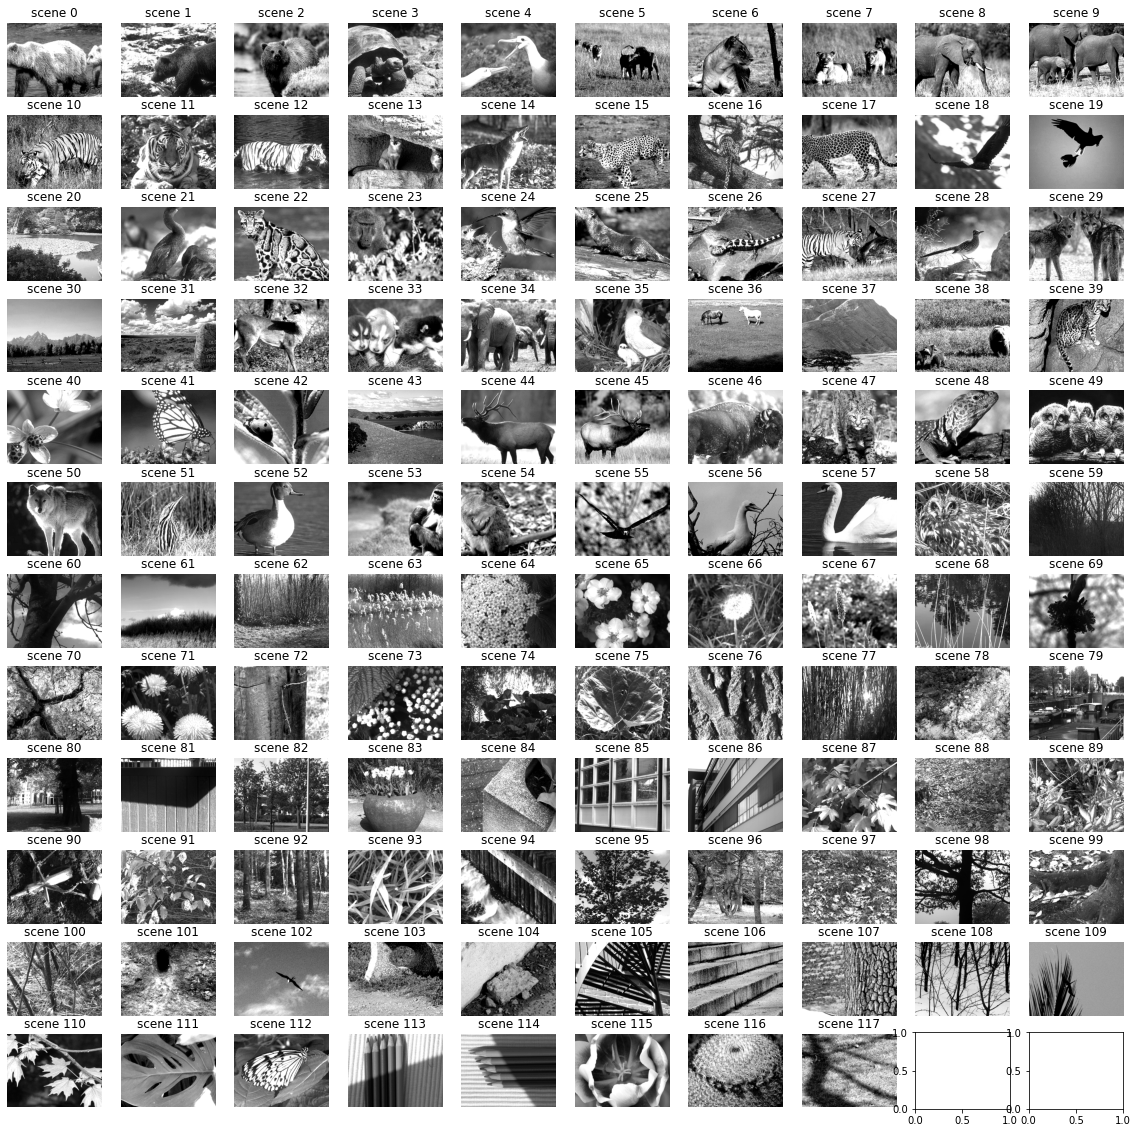

In [6]:
natural_scenes = session.stimulus_presentations[session.stimulus_presentations['stimulus_name']=='natural_scenes']

# Pull from where images are located.
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
data_set = boc.get_ophys_experiment_data(501498760)

# Show all scenes.
scene_nums = np.arange(0)

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

try:
    fig, axes = plt.subplots(12, 10, figsize=(20, 20))
    for i, ax in enumerate(axes.flat):
        ax.imshow(scenes[i], cmap='gray')
        ax.set_axis_off()
        ax.set_title('scene %d' % i)
except IndexError:
    pass # ignore the IndexError and continue running the code

- Below shows when two different images were shown.

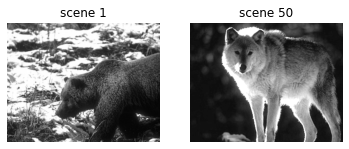

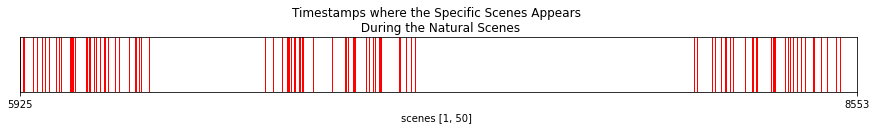

In [7]:
### Choose specific scenes to explore.
scene_nums = [1,50]

### Thank you to http://alleninstitute.github.io/AllenSDK/_static/examples/nb/brain_observatory_stimuli.html for this chunk.
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
data_set = boc.get_ophys_experiment_data(501498760)

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

# Define a function that takes two arguments: a dataframe containing information about stimulus trials and a title for the plot.
# The function plots the times each specified stimulus occurs throught the timeframe.
def plot_stimulus_table(natural_scenes, title):
    fstart = natural_scenes.start_time.min()
    fend = natural_scenes.stop_time.max()
    
    fig = plt.figure(figsize=(15,1))
    ax = fig.gca()
    # Loop over each trial in the dataframe
    for i, trial in natural_scenes.iterrows():    
        # Calculate the start and stop times for the trial.
        x1 = float(trial.start_time - fstart) / (fend - fstart)
        x2 = float(trial.stop_time - fstart) / (fend - fstart)      
        # Add a rectangle to the plot.
        ax.add_patch(patches.Rectangle((x1, 0.0), x2 - x1, 1.0, color='r'))
        
    ax.set_xticks((0,1))
    ax.set_xticklabels((int(np.round(fstart)), int(np.round(fend))))
    ax.set_yticks(())
    ax.set_title("Timestamps where the Specific Scenes Appears \n During the Natural Scenes")
    ax.set_xlabel(title)

# read in the array of images
scenes = data_set.get_stimulus_template('natural_scenes')

# display a couple of the scenes
fig, axes = plt.subplots(1,len(scene_nums))
for ax,scene in zip(axes, scene_nums):
    ax.imshow(scenes[scene,:,:], cmap='gray')
    ax.set_axis_off()
    ax.set_title('scene %d' % scene)
    
# build up a mask of trials for which one of a list of scenes is visible
trial_mask = natural_scenes.frame == -2
for scene in scene_nums:
    trial_mask |= (natural_scenes.frame == scene)
natural_scenes = natural_scenes[trial_mask]

# plot the trials
plot_stimulus_table(natural_scenes, "scenes %s " % scene_nums)

### 2.2) Visualize the unique firing pattern of different units.

This unique firing pattern allows one to differenciate between two possible neurons(units) and create a unique spike train for each.

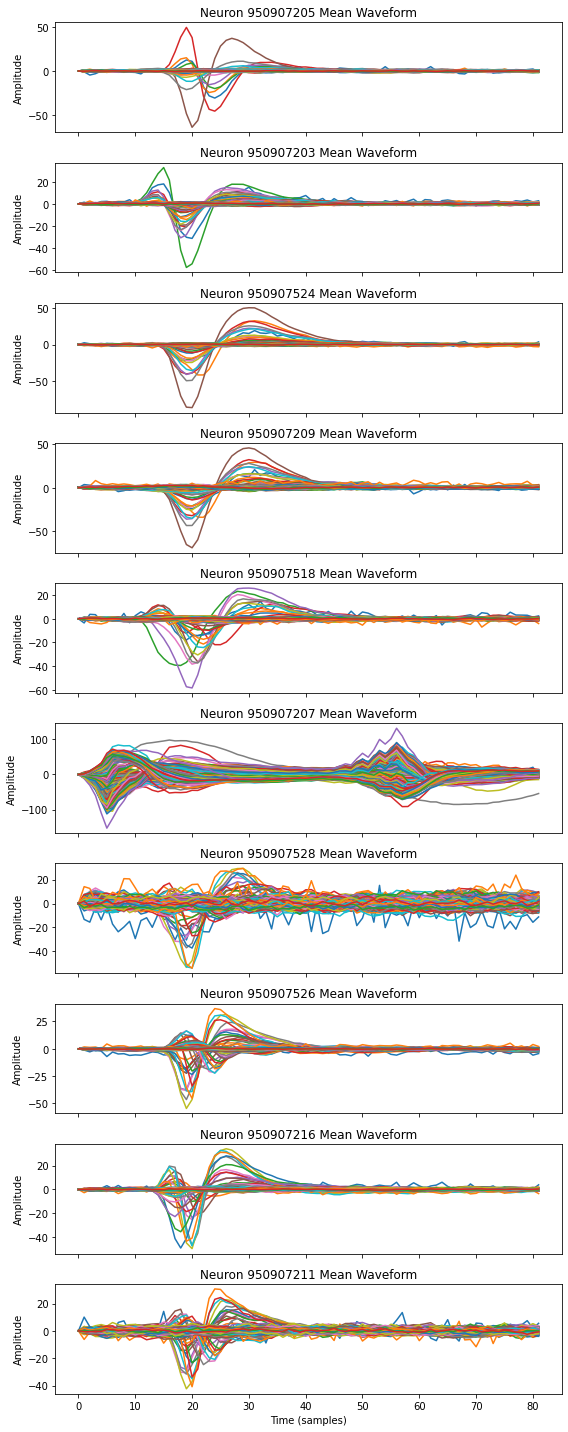

In [8]:
# Get the mean spike waveforms for each neuron
mean_waveforms = session.mean_waveforms

# Number of waveforms to display (you can change this value)
n_waveforms = 10
unit_ids = session.units.index.values

# Plot the mean spike waveforms for the first n_waveforms neurons
fig, axes = plt.subplots(n_waveforms, 1, figsize=(8, 2 * n_waveforms), sharex=True)
for i, (unit_id, ax) in enumerate(zip(unit_ids[:n_waveforms], axes)):
    waveform = mean_waveforms[unit_id]
    ax.plot(waveform.T)
    ax.set_title(f'Neuron {unit_id} Mean Waveform')
    ax.set_ylabel('Amplitude')
    ax.label_outer()

plt.xlabel('Time (samples)')
plt.tight_layout()
plt.show()


### 2.3) Raster plot of the spike trains for each neuron.

When the spike trains are created for each unique unit, they produce a 1 for every spike and 0 if they are not spiking at each timestep. The spike trains are plotted below for a few unique units over the natural scene time frame.

*** Add Raster Plot for binned data. ***

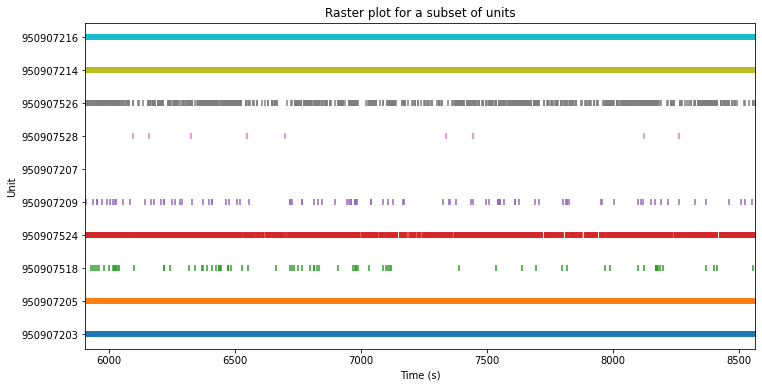

The following is the first 1000 timesteps of the data visualized. 1/30,000th of a second.
[0 1]


950907203  950907205  950907518  950907524  950907209  950907207  \
Time (s)                                                                        
5905.128132          0          0          0          0          0          0   
5905.128165          0          0          0          0          0          0   
5905.128199          0          0          0          0          0          0   
5905.128232          0          0          0          0          0          0   
5905.128265          0          0          0          0          0          0   
...                ...        ...        ...        ...        ...        ...   
5905.161266          0          0          0          0          0          0   
5905.161299          0          0          0          0          0          0   
5905.161332          0          0          0          0          0          0   
5905.161366          0          0          0          0          0          0   
5905.161399          0          0          0          0          0          0   

             950907528  950907526  950907214  950907216  
Time (s)                                                 
5905.128132          0          0          0          0  
5905.128165          0          0          0          0  
5905.128199          0          0          0          0  
5905.128232          0          0          0          0  
5905.128265          0          0          0          0  
...                ...        ...        ...        ...  
5905.161266          0          0          0          0  
5905.161299          0          0          0          0  
5905.161332          0          0          0          0  
5905.161366          0          0          0          0  
5905.161399          0          0          0          0  

[999 rows x 10 columns]

In [9]:
natural_scenes = session.stimulus_presentations[session.stimulus_presentations['stimulus_name'] == 'natural_scenes']
available_unit_ids = session.spike_times.keys()
all_spike_times = {unit_id: session.spike_times[unit_id] for unit_id in available_unit_ids}
units = cache.get_units()

# Create a function to build a raster plot.
def visualize_spike_data(num_units_to_visualize, all_spike_times, units, start_time=0, end_time=10, num_timesteps=30):
    # Select a subset of units to plot
    available_unit_ids = list(all_spike_times.keys())
    subset_unit_ids = available_unit_ids[:num_units_to_visualize]

    # Calculate the time_interval (in seconds) from the first unit's sampling rate
    time_interval = 1 / units.iloc[0]['sampling_rate']

    # Create the raster plot
    fig, ax = plt.subplots(figsize=(12, 6))

    for i, unit_id in enumerate(subset_unit_ids):
        spike_times = all_spike_times[unit_id]

        # Filter the spike times based on start_time and end_time
        filtered_spike_times = [t for t in spike_times if start_time <= t <= end_time]

        ax.scatter(filtered_spike_times, [i] * len(filtered_spike_times), marker='|')

    ax.set_xlim([start_time, end_time])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Unit')
    ax.set_yticks(range(len(subset_unit_ids)))
    ax.set_yticklabels(subset_unit_ids)
    ax.set_title('Raster plot for a subset of units')

    plt.show()

    # Create an array of time bins
    time_bins = np.arange(start_time, start_time + num_timesteps, time_interval)

    # Only consider the first 'num_timesteps' time bins
    time_bins = time_bins[:num_timesteps]

    # Initialize an empty DataFrame with the time bins as the index
    spike_counts_df = pd.DataFrame(index=time_bins[:-1])

    # Iterate through the units and count the spikes in each time bin
    for unit_id in subset_unit_ids:
        spike_times = all_spike_times[unit_id]
        spike_counts, _ = np.histogram(spike_times, bins=time_bins)
        spike_counts_df[unit_id] = spike_counts

    # Rename the index
    spike_counts_df.index.name = 'Time (s)'

    return spike_counts_df

# Example usage:
num_units_to_visualize = 10
start_time = natural_scenes.start_time.min()
end_time = natural_scenes.stop_time.max()
num_timesteps = 1000

spike_counts_df = visualize_spike_data(num_units_to_visualize, all_spike_times, units, start_time, end_time, num_timesteps)
print('The following is the first 1000 timesteps of the data visualized. 1/30,000th of a second.')
print(np.unique(spike_counts_df))
spike_counts_df

### 2.4) Sorted correlation matrix between Units

Below is a sorted correlation matrix between units based on their firing rates. A clustering method called Agglomerative hierarchical cluster was group the correlation matrix.  

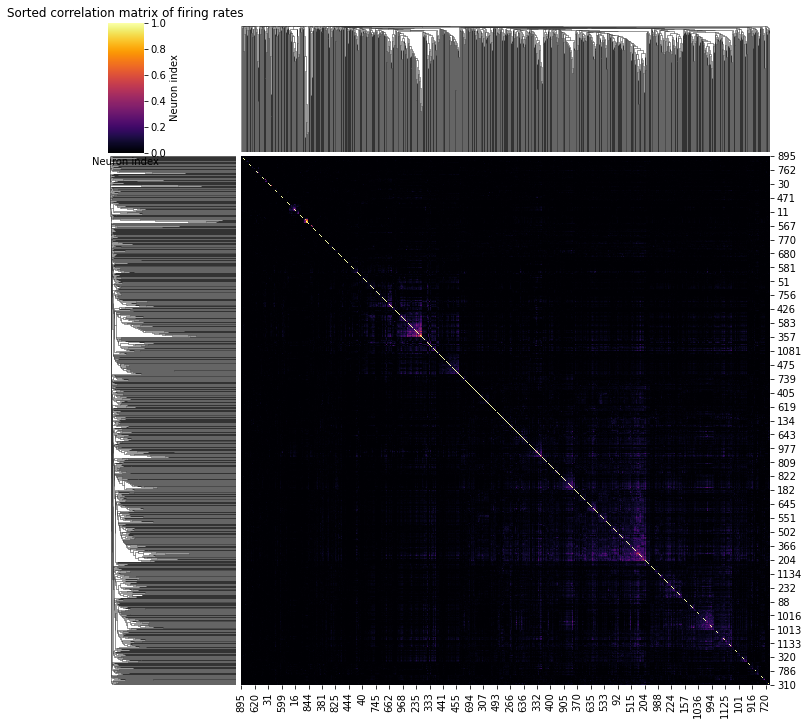

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

X = filtered_normalized_firing_rates.drop(columns=['frame'])

### This function calculates the correlation coefficient between each pair of neurons in the input matrix X (in our case, firing rates).
def custom_corrcoef(X):
    # Calculate the correlation coefficient matrix by taking the dot product of the normalized matrix and its transpose
    # Divide the result by the number of columns in X to normalize the sum
    return np.dot(X, X.T) / X.shape[1]

# Calculate the correlation matrix
corr_matrix = custom_corrcoef(X.T)

# Compute the hierarchical clustering
distance_matrix = 1 - np.abs(corr_matrix)
np.fill_diagonal(distance_matrix, 0)  # Set the diagonal to zero
linked = linkage(squareform(distance_matrix), method='average')  # The linkage function performs the cluster.

# Plot the heatmap with dendrogram-based sorting
sns.clustermap(corr_matrix, cmap='inferno', row_linkage=linked, col_linkage=linked, vmin=0, vmax=1)
plt.title("Sorted correlation matrix of firing rates")
plt.xlabel("Neuron index")
plt.ylabel("Neuron index")
plt.show()

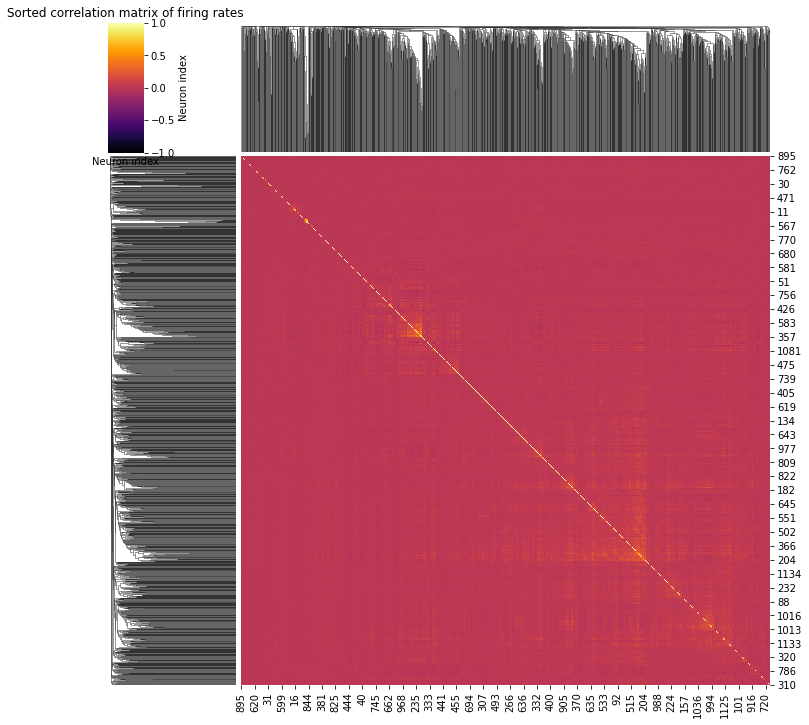

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

X = filtered_normalized_firing_rates.drop(columns=['frame'])

### This function calculates the correlation coefficient between each pair of neurons in the input matrix X (in our case, firing rates).
def custom_corrcoef(X):
    # Calculate the correlation coefficient matrix by taking the dot product of the normalized matrix and its transpose
    # Divide the result by the number of columns in X to normalize the sum
    return np.dot(X, X.T) / X.shape[1]

# Calculate the correlation matrix
corr_matrix = custom_corrcoef(X.T)

# Compute the hierarchical clustering
distance_matrix = 1 - np.abs(corr_matrix)
np.fill_diagonal(distance_matrix, 0)  # Set the diagonal to zero
linked = linkage(squareform(distance_matrix), method='average') 

# Plot the heatmap with dendrogram-based sorting
sns.clustermap(corr_matrix, cmap='inferno', row_linkage=linked, col_linkage=linked, vmin=-1, vmax=1)
plt.title("Sorted correlation matrix of firing rates")
plt.xlabel("Neuron index")
plt.ylabel("Neuron index")
plt.show()

### 2. ) Grouped Heat Maps of Unit Resposes by Frames

/tmp/ipykernel_1816090/1663547482.py:3: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corrwith(df['frame'], method='spearman')


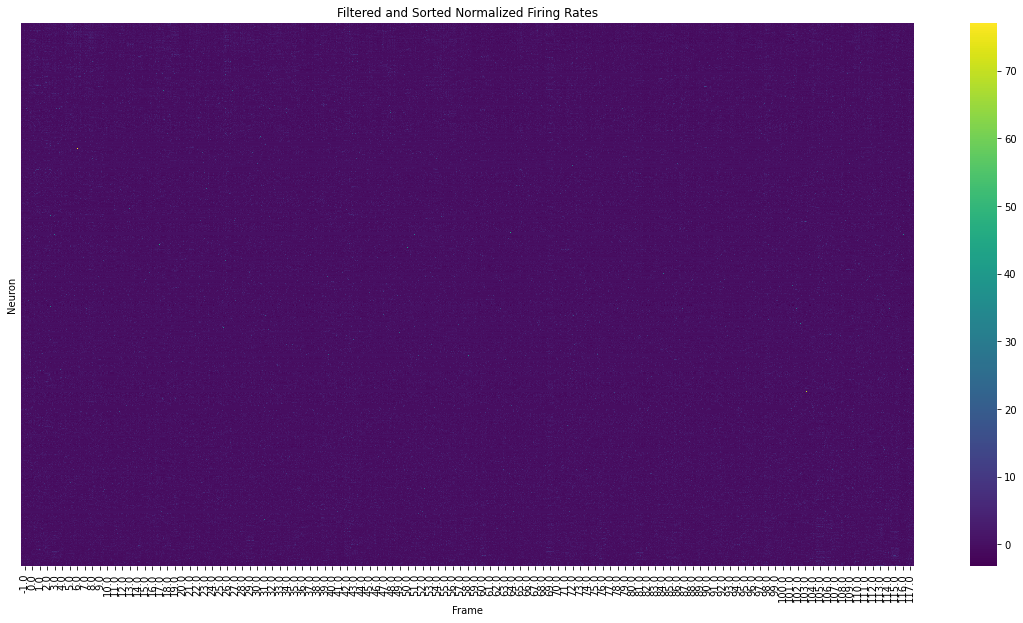

In [15]:
def plot_filtered_normalized_firing_rates(df, num_frames):
    # Calculate the correlation between the firing rates and frames
    correlation_matrix = df.corrwith(df['frame'], method='spearman')

    # Sort neurons by their correlation with the 'frame' column
    sorted_neurons = correlation_matrix[df.columns[1:]].sort_values().index.tolist()

    # Filter the DataFrame based on the desired number of frames
    filtered_df = df.head(num_frames)

    # Sort neurons by their correlation with the 'frame' column
    sorted_filtered_df = filtered_df[['frame'] + sorted_neurons]

    # Sort the DataFrame by the 'frame' column
    sorted_filtered_df.sort_values(by='frame', inplace=True)

    # Set the 'frame' column as the index of the DataFrame
    sorted_filtered_df.set_index('frame', inplace=True)

    # Create a heatmap for the filtered and sorted DataFrame
    plt.figure(figsize=(20, 10))
    ax = sns.heatmap(sorted_filtered_df.T, cmap='viridis', yticklabels=False)

    # Get unique frame values
    unique_frames = sorted_filtered_df.index.unique()

    # Set x-ticks at the middle of each frame group
    ax.set_xticks([np.where(sorted_filtered_df.index == frame)[0].mean() for frame in unique_frames])

    # Set x-tick labels to be the frame numbers
    ax.set_xticklabels(unique_frames)

    plt.xlabel('Frame')
    plt.ylabel('Neuron')
    plt.title(f'Filtered and Sorted Normalized Firing Rates')
    plt.show()

# Use the function with the desired parameters
plot_filtered_normalized_firing_rates(firing_rates_per_frame, num_frames=None)

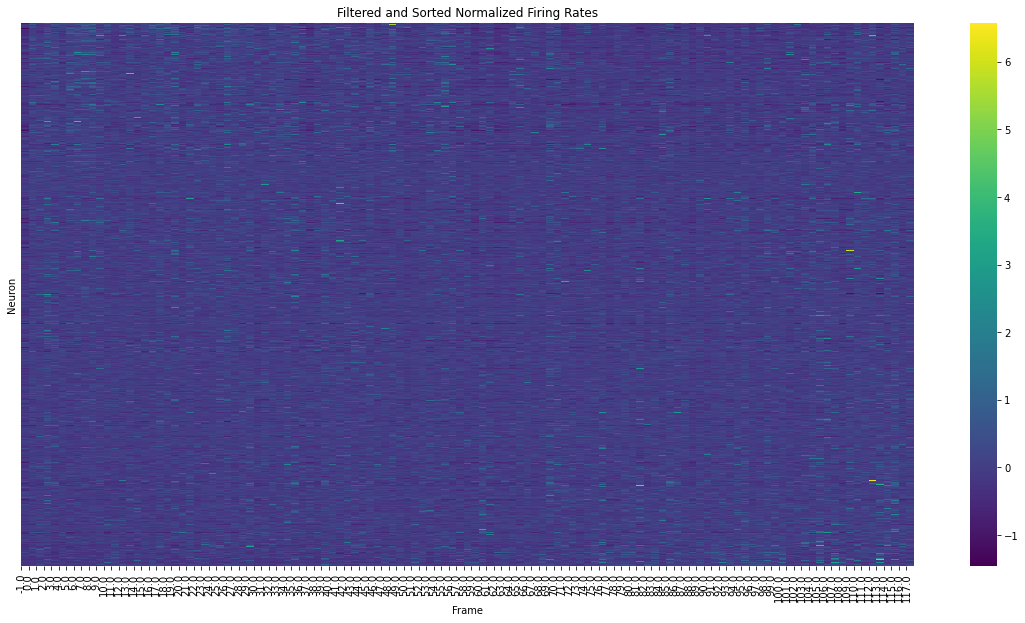

In [17]:
# Use the function with the desired parameters
plot_filtered_normalized_firing_rates(average_firing_rate, num_frames=None)

/nas/longleaf/rhel8/apps/anaconda/2021.11.ood/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


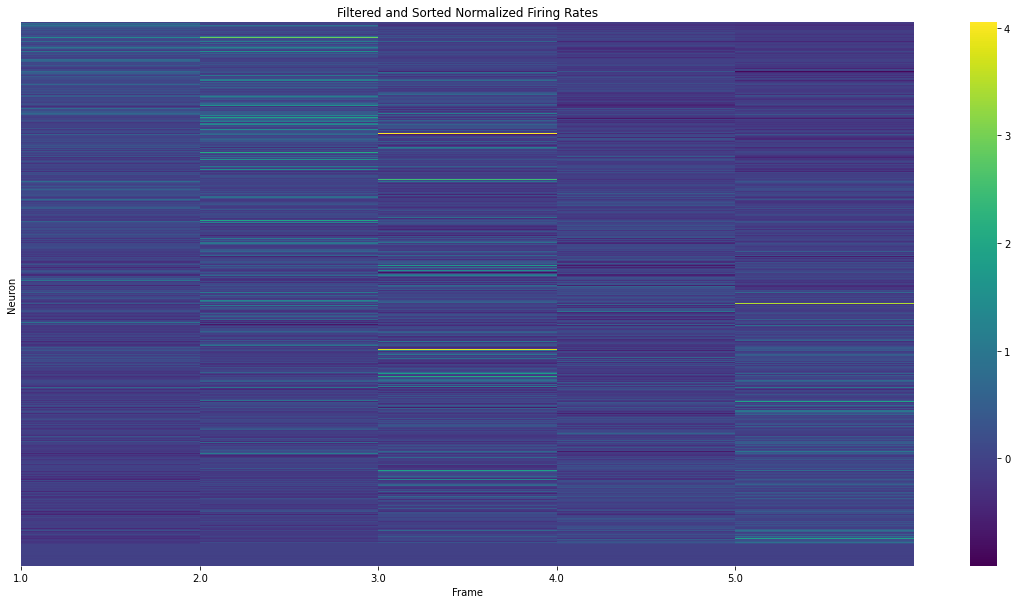

In [18]:
# select only frames 0, 1, 2, 3, 4, 5
frames_to_select = [1,2,3,4,5]
select_images = average_firing_rate[average_firing_rate['frame'].isin(frames_to_select)]
select_images

plot_filtered_normalized_firing_rates(select_images, num_frames=None)

### 2.) T-SNE Plot All Neurons

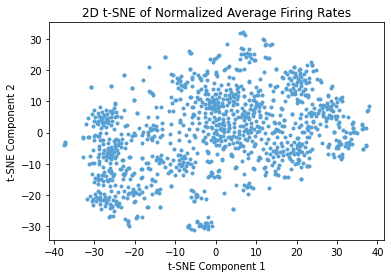

In [51]:
### Pre-process for t-SNE.

# Drop the 'frame' column and convert the DataFrame to a NumPy array
tsne_df = filtered_normalized_firing_rates.drop(columns=['frame'])
tsne_array = np.array(tsne_df).transpose()

# Perform 2D t-SNE.
tsne_2d = TSNE(n_components=2, random_state=69)
tsne_2d_results = tsne_2d.fit_transform(tsne_array)

# Plot 2D t-SNE with Carolina blue color
plt.scatter(tsne_2d_results[:, 0], tsne_2d_results[:, 1], color=carolina_blue, marker='.')
plt.title('2D t-SNE of Neurons Shown 117 different Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

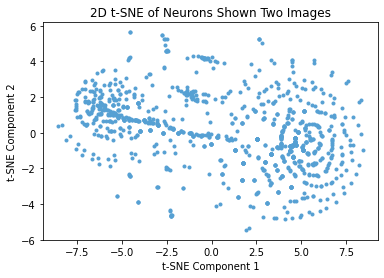

In [60]:
# select only frames 0, 1, 2, 3, 4, 5
frames_to_select = [1,9]
select_images = filtered_normalized_firing_rates[filtered_normalized_firing_rates['frame'].isin(frames_to_select)]


# Drop the 'frame' column and convert the DataFrame to a NumPy array
tsne_df = select_images.drop(columns=['frame'])

tsne_array = np.array(tsne_df).transpose()
# Perform 2D t-SNE.
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_2d_results = tsne_2d.fit_transform(tsne_array)

# Plot 2D t-SNE with Carolina blue color
plt.scatter(tsne_2d_results[:, 0], tsne_2d_results[:, 1], color=carolina_blue, marker='.')
plt.title('2D t-SNE of Neurons Shown Two Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


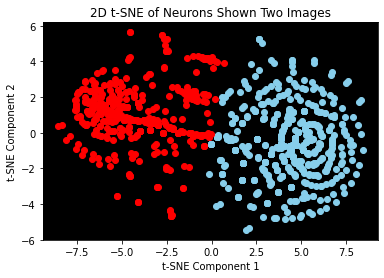

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# select only frames 0, 1, 2, 3, 4, 5
frames_to_select = [1,9]
select_images = filtered_normalized_firing_rates[filtered_normalized_firing_rates['frame'].isin(frames_to_select)]

# Drop the 'frame' column and convert the DataFrame to a NumPy array
tsne_df = select_images.drop(columns=['frame'])

tsne_array = np.array(tsne_df).transpose()
# Perform 2D t-SNE.
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_2d_results = tsne_2d.fit_transform(tsne_array)

# Define the number of clusters
num_clusters = 2  # Change this to the number of clusters you want

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tsne_2d_results)

# Get the cluster labels
labels = kmeans.labels_

# Define the colors for each cluster
colors = ['skyblue', 'red']  # Change these to the colors you want

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot 2D t-SNE with colors representing different clusters
for i in range(num_clusters):
    plt.scatter(tsne_2d_results[labels == i, 0], tsne_2d_results[labels == i, 1], color=colors[i])

plt.title('2D t-SNE of Neurons Shown Two Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# plt.legend()  # Commented out to remove the legend
plt.show()

### 2.) Show Average Firing Rates of Different Neurons per frame

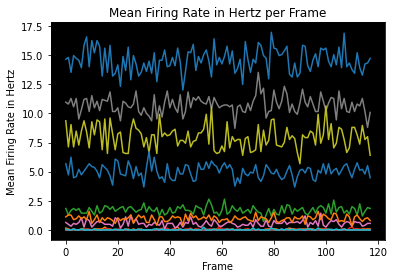

In [71]:
# Choose how many neurons to display.
num_of_neurons_display = 12

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
firing_rate_hz.iloc[:,1:(num_of_neurons_display+1)].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Mean Firing Rate in Hertz')
plt.title('Mean Firing Rate in Hertz per Frame')

# Show the plot
plt.show()

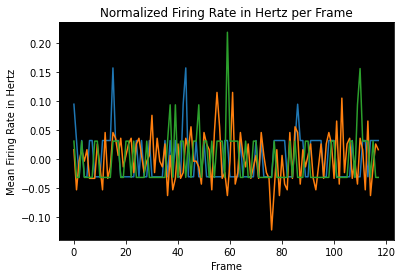

In [67]:
normalized_spikes_per_frame = filtered_normalized_firing_rates.groupby('frame').mean().iloc[1:,1:]
normalized_spikes_per_frame.reset_index(inplace=True)

# Choose how many neurons to display.
num_of_neurons_display = 3

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
normalized_spikes_per_frame.iloc[:,1:(num_of_neurons_display+1)].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Mean Firing Rate in Hertz')
plt.title('Normalized Firing Rate in Hertz per Frame')

# Show the plot
plt.show()

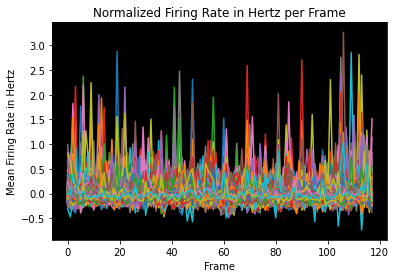

In [68]:
normalized_spikes_per_frame = filtered_normalized_firing_rates.groupby('frame').mean().iloc[1:,1:]
normalized_spikes_per_frame.reset_index(inplace=True)

# Set the background color to black
plt.rcParams['axes.facecolor'] = 'black'

# Plot the firing rate for each neuron
normalized_spikes_per_frame.iloc[:,1:].plot(kind='line', legend=False)

# Add labels and title
plt.xlabel('Frame')
plt.ylabel('Mean Firing Rate in Hertz')
plt.title('Normalized Average Firing Rate in Hertz per Frame')

# Show the plot
plt.show()

<a name="step3content"></a>
## 3. Image Prediction Modeling
[Go to Outline](#outline)

The goal of the image prediction modeling is to predict what image is shown based on the neuropixel data given.

3.1) Baseline Model
Our baseline model assumes a random guess, with an accuracy of 0.85% (1/117).

3.2) Support Vector Machine with Radial Basis Function
We will use a Support Vector Machine with a Radial Basis Function as our first prediction model.

3.3) Principal Component Regression.
Next, we will apply Principal Component Regression for image prediction.

3.4) Neural Networks with Different Architectures
Lastly, we will experiment with Neural Networks of varying architectures to optimize prediction accuracy.

3.5) Build a Statitic Spatio-Temporal Graph Neural Network

### 3.2) Create train and test splits.

In [64]:
from sklearn.preprocessing import LabelEncoder

# Create X and y.
y = filtered_normalized_firing_rates['frame'].values
X = filtered_normalized_firing_rates.drop(columns=['frame']).values

# Encode class labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, shuffle = False)

num_classes = len(np.unique(y))
input_dim = X_train.shape[-1]


print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train type: <class 'torch.Tensor'>
X_train shape: torch.Size([47600, 1141])
y_train shape: torch.Size([47600])
X_test type: <class 'torch.Tensor'>
X_test shape: torch.Size([11900, 1141])
y_test shape: torch.Size([11900])


### 3.3) Baseline Model
- The baseline model assumes a random guess, with an accuracy of 0.85% (1/117).

In [ ]:
print(f'Test Accuracy: {np.round(1/117*100, 2)}%')

### 3.4) SVM with a Radial Kernel.

In [4]:
# Create and train the SVM model with a radial kernel
model = SVR(kernel='rbf', C=1.0, gamma='scale')
model.fit(X_train, y_train)

# Make predictions on the test set and round them to the nearest integer
y_pred = model.predict(X_test)
y_pred_rounded = [round(pred) for pred in y_pred]

# Calculate the accuracy of the model
correct_predictions = np.sum(np.equal(y_test, y_pred_rounded))
accuracy = correct_predictions / len(y_test) * 100
print(f"SVM Accuracy: {accuracy:.2f}%")

TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [31]:
import torch
from torch.autograd import Variable

# Define the RBF kernel
def rbf_kernel(x1, x2, sigma=1.0):
    x1 = x1.unsqueeze(1)  # Shape: [N1, 1, D]
    x2 = x2.unsqueeze(0)  # Shape: [1, N2, D]
    squared_distance = ((x1 - x2) ** 2).sum(2)  # Shape: [N1, N2]
    return torch.exp(-squared_distance / (2 * sigma ** 2))  # Shape: [N1, N2]

class SVM(torch.nn.Module):
    def __init__(self, n_features, n_classes):
        super(SVM, self).__init__()
        self.n_classes = n_classes
        self.alphas = torch.nn.Parameter(torch.randn(n_features, n_classes))  # Change this line
        
    def forward(self, x):
        kernel_matrix = rbf_kernel(x, x)
        output = kernel_matrix @ self.alphas
        return output

# Define the loss function (hinge loss)
def hinge_loss(outputs, labels):
    labels = torch.eye(svm.n_classes)[labels]  # One-hot encoding
    return torch.mean(torch.clamp(1 - outputs.t() * labels, min=0))  # Element-wise hinge loss

# Instantiate the SVM
svm = SVM(n_features=X_train.shape[1], n_classes=len(torch.unique(y_train)))

# Define the optimizer
optimizer = torch.optim.SGD(svm.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    optimizer.zero_grad()
    outputs = svm(X_train)
    loss = hinge_loss(outputs, y_train)
    loss.backward()
    optimizer.step()


RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 10340928640000 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
# Create and train the SVM model with a radial kernel
model = SVR(kernel='rbf', C=.5, gamma='scale')
model.fit(X_train, y_train)

# Make predictions on the test set and round them to the nearest integer
y_pred = model.predict(X_test)
y_pred_rounded = [round(pred) for pred in y_pred]

# Calculate the accuracy of the model
correct_predictions = sum(y_test == y_pred_rounded)
accuracy = correct_predictions / len(y_test) * 100
print(f"SVM Accuracy: {accuracy:.2f}%")


### 3.5) Run Principal Component Regression.

In [ ]:
### A basic PCR.
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a pipeline for PCR
n_components = 10  # Adjust the number of components based on your data
pcr = Pipeline([
    ('pca', PCA(n_components=n_components)),
    ('linear_regression', LinearRegression())
])

# Train the PCR model
pcr.fit(X_train, y_train)

# Predict the test set
y_pred = pcr.predict(X_test)

# Convert predictions and true labels to integers (since you mentioned that each number represents a picture)
y_pred_int = np.round(y_pred).astype(int)
y_test_int = y_test.astype(int)

# Calculate the accuracy
accuracy = accuracy_score(y_test_int, y_pred_int)
print(f"PCR accuracy: {np.round(accuracy*100, 2)}%")

### 3.6) Neural Network Models

Supports the use of Deep neural netowrks over linear models. http://cs230.stanford.edu/projects_winter_2021/reports/70532925.pdf

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

def torch_nn(num_of_neurons_in_dense, batch_size, epochs):
    # Define the model
    class Net(nn.Module):
        def __init__(self, input_dim, num_of_neurons_in_dense, num_classes):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(input_dim, num_of_neurons_in_dense)
            self.fc2 = nn.Linear(num_of_neurons_in_dense, num_classes)

        def forward(self, x):
            x = torch.sigmoid(self.fc1(x))
            x = self.fc2(x)
            return x

    # Create DataLoaders
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Instantiate the model
    model = Net(X_train.shape[1], num_of_neurons_in_dense, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Training loop
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return print(f'Model Test Accuracy: {100 * correct / total:.2f}%')

num_of_neurons_in_dense = 1000
batch_size = 64
epochs = 30

torch_nn(num_of_neurons_in_dense, batch_size, epochs)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (640x1141 and 10x1000)

In [25]:
import matplotlib.pyplot as plt

def torch_nn_grid_search(neuron_range, batch_size, epochs):
    accuracies = []

    for num_of_neurons_in_dense in neuron_range:
        # Define the model
        class Net(nn.Module):
            def __init__(self, input_dim, num_of_neurons_in_dense, num_classes):
                super(Net, self).__init__()
                self.fc1 = nn.Linear(input_dim, num_of_neurons_in_dense)
                self.fc2 = nn.Linear(num_of_neurons_in_dense, num_classes)

            def forward(self, x):
                x = torch.sigmoid(self.fc1(x))
                x = self.fc2(x)
                return x

        # Instantiate the model
        model = Net(X_train.shape[1], num_of_neurons_in_dense, num_classes)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())

        # Training loop
        for epoch in range(epochs):
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluation
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Neurons: {num_of_neurons_in_dense}, Test Accuracy: {accuracy:.2f}%')

    # Plot the accuracies
    plt.plot(neuron_range, accuracies, marker='o')
    plt.title('Model Accuracy vs. Number of Neurons in Dense Layer')
    plt.xlabel('Number of Neurons')
    plt.ylabel('Model Test Accuracy')
    plt.grid(True)
    plt.show()

neuron_range = range(50, 2000, 50)
batch_size = 64
epochs = 30

torch_nn_grid_search(neuron_range, batch_size, epochs)

Neurons: 100, Accuracy: 24.29%
Neurons: 150, Accuracy: 24.62%
Neurons: 200, Accuracy: 25.87%
Neurons: 250, Accuracy: 26.53%


KeyboardInterrupt: 

In [24]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

def torch_nn(num_of_neurons_in_dense, batch_size, epochs):
    # Define the model
    class Net(nn.Module):
        def __init__(self, input_dim, num_of_neurons_in_dense, num_classes):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(input_dim, num_of_neurons_in_dense)
            self.fc2 = nn.Linear(num_of_neurons_in_dense, num_of_neurons_in_dense // 2)
            self.fc3 = nn.Linear(num_of_neurons_in_dense // 2, num_of_neurons_in_dense // 4)
            self.fc4 = nn.Linear(num_of_neurons_in_dense // 4, num_classes)

        def forward(self, x):
            x = torch.sigmoid(self.fc1(x))
            x = torch.sigmoid(self.fc2(x))
            x = torch.sigmoid(self.fc3(x))
            x = self.fc4(x)
            return x


    # Create DataLoaders
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Instantiate the model
    model = Net(X_train.shape[1], num_of_neurons_in_dense, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Training loop
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return print(f'Model with multiple layers Test Accuracy: {100 * correct / total:.2f}%')

num_of_neurons_in_dense = 1000
batch_size = 64
epochs = 30

torch_nn(num_of_neurons_in_dense, batch_size, epochs)

Model Accuracy: 18.87%


### 3.6) LSTM model

The purpose of the following Long Short-Term Memory (LSTM) model is to account for temporal dependencies while using deep learning to predict a categorical outcome. Given a sequence of inputs $x_1, . . . , x_T$, the LSTM model attempts to predict a corresponding sequence of outputs $y_1, . . . , y_{T'}$. The sequence of inputs are the firing rates of indivual units and the sequence of outputs is the log probability for each frame. It does this by two states, one for long term time dependencies and one for short term. These are referred to as the cell and hidden states. In our model, we make a prediction from the frame that has the highest log probability.

Formally, this can be described as the LSTM model learning a probability distribution over sequences of outputs conditioned on sequences of inputs, expressed as:

$$
p(y_1, . . . , y_{T'} | x_1, . . . , x_T ) = \prod_{t=1}^{T'} p(y_t|h_{t-1}, c_{t-1}, x_t)
$$

where $x_t$ is the firing rate at time $t$, $y_t$ is the log probability of the frames at time $t$, $h_{t-1}$ is the hidden state at time $t-1$, and $c_{t-1}$ is the cell state at time $t-1$.

The ability to selectively forget information comes from its gating mechanisms. This is useful for when time dependencies might change. Each frame is shown for a quarter of a second, or 0.25 seconds. Our data has been processed where each frame is split between 10 rows. When we are making a prediction about each frame we will guess 10 times. At each of these predictions, the temporal dependecy will be different. As we the frame shown before is completely irrelevant. In the first out of 10 guesses there won't be a temporal dependency and in the last out of the 10 there will possibly be 9 relevant timesteps. (Unless the mouse begins to expect a new image as the last one was shown. This would make previous timesteps from another frame relevant. However, the forget gate should be able to pick up on that.) 

Reference: Sutskever, I., Vinyals, O., & Le, Q. V. (2014). Sequence to sequence learning with neural networks. In Advances in Neural Information Processing Systems (pp. 3104-3112). Retrieved from 

This LSTM cell takes as input the current firing rate of each neuron $x_t$ and the previous hidden state $h_{t-1}$, and outputs a new hidden state $h_t$ and a new cell state $c_t$. The hidden state represents the short term memory while the cell state represents the long term memory. This process can be described by the following equations:

- Forget gate:
    $$
    f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
    $$

- Input gate:
    $$
    i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
    $$

- Candidate cell state:
    $$ 
    \tilde{c}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
    $$

- Update cell state:
    $$
    c_t = f_t * c_{t-1} + i_t * \tilde{c}_t
    $$

- Output gate:
    $$
    o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
    $$

- Update hidden state:
    $$
    h_t = o_t * \tanh(c_t)
    $$
- Output layer:
    $$
     {y}_t = W_y \cdot h_t + b_y 
    $$

- Prediction:
    $$
    \hat{y}_t = max(y_t)
    $$


Here, $W_y$ represents the weight matrix for the output layer, $b_y$ represents the bias term for the output layer, and $h_t$ is the last hidden state from the LSTM. The operation $\cdot$ is the dot product.
The output ${y}_t$ is a vector of size equal to the number of classes in the output space. $\hat{y}_t$ Each element of this vector represents the score for a particular class. The class with the highest score is the model's prediction.

LSTM Parameters

- $x_t$: the input vector at time $t$. This is the firing rates of all neurons at time $t$.

- $h_{t-1}$: the hidden state at time $t-1$, i.e., the output of the LSTM cell from the previous time step. It also represents the past short term memory.

- $c_{t-1}$: the cell state at time $t-1$, i.e., the internal memory of the LSTM cell from the previous time step. Similar to the past long term memory.

- $W_f, W_i, W_C, W_o, W_y$: weight matrices for the forget gate, input gate, cell candidate, output gate, and output layer respectively.

- $b_f, b_i, b_C, b_o, b_y$: bias terms for the forget gate, input gate, cell candidate, output gate, and the output layer respectively.

- $f_t, i_t, \tilde{c}_t, o_t$: the outputs of the forget gate, input gate, cell candidate, and output gate at time $t$, respectively.

- $c_t$: the cell state at time $t$, which is a combination of the previous cell state and the current cell candidate, controlled by the forget gate and input gate.

- $h_t$: the hidden state at time $t$, which is a filtered version of the cell state, controlled by the output gate.

- ${y}_t$: the output vector of log probabilities for each frame at that timestep.

- $\hat{y}_t$: is the prediction for that timestep.


References - Paper model overview: http://www.bioinf.jku.at/publications/older/2604.pdf \
    -Paper above model is modeled after: https://proceedings.neurips.cc/paper_files/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf \
    -Explanation - This guy worked at the stats dept at UNC I believe. https://www.youtube.com/watch?v=YCzL96nL7j0&ab_channel=StatQuestwithJoshStarmer \
    -step by step: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [8]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming 'filtered_normalized_firing_rates' is your DataFrame
# and 'frame' is your target column

# Create X and y.
X = filtered_normalized_firing_rates.drop(columns=['frame']).values
y = filtered_normalized_firing_rates['frame'].values

# Encode categorical target values
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Create train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, shuffle=False)

# Set sequence length and determine new number of samples
seq_len = 10 # Set sequence length
num_samples_train = X_train.shape[0] // seq_len
num_features = X_train.shape[1]

# Determine the new number of samples.
num_samples_test = X_test.shape[0] // seq_len

# Reshape input to have 3 dimensions. (samples, timesteps, features/units)
X_train = X_train[:num_samples_train*seq_len]  
X_train = X_train.reshape(num_samples_train, seq_len, num_features)

# Reshape output to match input
y_train = y_train[:num_samples_train*seq_len]  # Make the total length divisible by seq_len
y_train = y_train.reshape(num_samples_train, seq_len, 1)  # Keep as 2D tensor
y_train = y_train[:, -1]  # Predicting a single value for each sequence

# Reshape input to be 3D (samples, timesteps, features)
X_test = X_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
X_test = X_test.reshape(num_samples_test, seq_len, num_features)

# Reshape output to match input
y_test = y_test[:num_samples_test*seq_len]  # Make the total length divisible by seq_len
y_test = y_test.reshape(num_samples_test, seq_len, 1)  # Keep as 2D tensor
y_test = y_test[:, -1]  # Predicting a single value for each sequence

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Convert numpy arrays to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train type: <class 'torch.Tensor'>
X_train shape: torch.Size([4760, 10, 1141])
y_train shape: torch.Size([4760, 1])
X_test type: <class 'torch.Tensor'>
X_test shape: torch.Size([1190, 10, 1141])
y_test shape: torch.Size([1190, 1])


In [33]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# LSTM Model Parameters
input_dim = X_train.shape[-1]  # replace with the input dimension
hidden_dim = 250 # replace with the hidden dimension
layer_dim = 1 # replace with the layer dimension; usually between 1-3
output_dim = num_classes  # replace with the output dimension

# Training Parameters
sequence_length = seq_len  # replace with the sequence length
input_size = input_dim  # replace with the input size
learning_rate = 0.001  # replace with the learning rate
num_epochs = 10  # replace with the number of epochs
batch_size = 64  # You can adjust this value according to your preference and memory capacity


# This is your existing LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) # Fully connected layer

    def forward(self, x):
        # Initialize hidden and cell states. h0 and c0 respectively.
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Forward propagate the LSTM.
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :]) 
        
        return out

# Create the LSTM model.
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)

# Set the loss function and optimizer.
criterion = nn.CrossEntropyLoss()  # use cross entropy loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert test data to tensor in preperation for the laoder.
X_test_tensor = torch.Tensor(X_test).view(-1, sequence_length, input_dim).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create DataLoaders for training and testing data.
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(list(zip(X_test_tensor, y_test_tensor)), batch_size=batch_size, shuffle=True)

# Set total of test samples.
total_test_samples = len(X_test)

# Training loop
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    train_running_loss = 0.0  # Initialize running loss to 0.0
    correct_train_preds = 0.0  # Initialize the number of correct predictions to 0.0
    total_train_samples = 0.0  # Initialize the total number of training samples to 0.0
    correct = 0
    # Training step
    for i, (features, labels) in enumerate(train_loader):  # Loop over the training data
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device

        # Forward pass
        out = model(features)  # Pass the features through the model to get the output

        # Flatten labels to a 1D tensor
        labels = labels.view(-1)  # Flatten the labels

        # If labels are one-hot encoded, convert to class indices
        if labels.dim() > 1:  # If the labels are one-hot encoded
            labels = torch.argmax(labels, dim=1)  # Convert to class indices

        # Ensure labels are of the correct data type
        labels = labels.long()  # Convert labels to long type
        
        # Compute the loss
        loss = criterion(out, labels)  # Compute the loss between the output and the labels

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()  # Perform a backward pass to compute the gradients
        optimizer.step()  # Perform an optimization step to update the parameters

        train_running_loss += loss.detach().item()  # Add the loss to the running loss
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct_train_preds += (preds == labels).sum().item()  # Add the number of correct predictions to the total
        total_train_samples += labels.shape[0]  # Add the number of labels to the total number of samples

    model.eval()  # Set the model to evaluation mode
    correct_test_preds = 0.0  # Initialize the number of correct test predictions to 0.0
    total_test_samples = 0.0  # Initialize the total number of test samples to 0.0
    
    # Test step
    for i, (features, labels) in enumerate(test_loader):  # Loop over the test data
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device
        labels = labels.squeeze()  # Remove the extra dimension from the labels tensor
        out = model(features)  # Pass the features through the model to get the output
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct = (preds == labels).sum().item()  # Compute the number of correct predictions
        correct_test_preds += correct  # Add the number of correct predictions to the total
        total_test_samples += labels.shape[0]  # Add the number of labels to the total number of samples


    train_acc = correct_train_preds / total_train_samples * 100  # Compute the training accuracy
    test_acc = correct_test_preds / total_test_samples * 100  # Compute the test accuracy

    print(f'Epoch {epoch+1}, Loss: {np.round(train_running_loss/i,2)}, Train Acc: {np.round(train_acc,2)}%, Test Acc: {np.round(test_acc,2)}%')

Epoch 1, Loss: 18.88, Train Acc: 11.76%, Test Acc: 32.86%
Epoch 2, Loss: 9.97, Train Acc: 79.27%, Test Acc: 67.73%
Epoch 3, Loss: 2.5, Train Acc: 95.31%, Test Acc: 74.96%
Epoch 4, Loss: 0.46, Train Acc: 99.87%, Test Acc: 75.71%
Epoch 5, Loss: 0.15, Train Acc: 100.0%, Test Acc: 76.22%
Epoch 6, Loss: 0.08, Train Acc: 100.0%, Test Acc: 76.89%
Epoch 7, Loss: 0.06, Train Acc: 100.0%, Test Acc: 76.97%
Epoch 8, Loss: 0.04, Train Acc: 100.0%, Test Acc: 77.9%
Epoch 9, Loss: 0.04, Train Acc: 100.0%, Test Acc: 77.9%
Epoch 10, Loss: 0.03, Train Acc: 100.0%, Test Acc: 78.15%


In [16]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

# LSTM Model Parameters
input_dim = X_train.shape[-1]  # replace with the input dimension
hidden_dim = 250 # replace with the hidden dimension
layer_dim = 1 # replace with the layer dimension; usually between 1-3
output_dim = num_classes  # replace with the output dimension

# Training Parameters
sequence_length = seq_len  # replace with the sequence length
input_size = input_dim  # replace with the input size
learning_rate = 0.001  # replace with the learning rate
num_epochs = 10  # replace with the number of epochs
batch_size = 64  # You can adjust this value according to your preference and memory capacity


# This is your existing LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim) # Fully connected layer

    def forward(self, x):
        # Initialize hidden and cell states. h0 and c0 respectively.
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        # Forward propagate the LSTM.
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :]) 
        
        return out

# Create the LSTM model.
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)

# Set the loss function and optimizer.
criterion = nn.CrossEntropyLoss()  # use cross entropy loss function for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert test data to tensor in preperation for the laoder.
X_test_tensor = torch.Tensor(X_test).view(-1, sequence_length, input_dim).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create DataLoaders for training and testing data.
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(list(zip(X_test_tensor, y_test_tensor)), batch_size=batch_size, shuffle=True)

# Set total of test samples.
total_test_samples = len(X_test)

# Training loop
for epoch in range(num_epochs):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    train_running_loss = 0.0  # Initialize running loss to 0.0
    correct_train_preds = 0.0  # Initialize the number of correct predictions to 0.0
    total_train_samples = 0.0  # Initialize the total number of training samples to 0.0
    
    # Training step
    for i, (features, labels) in enumerate(train_loader):  # Loop over the training data
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device

        # Forward pass
        out = model(features)  # Pass the features through the model to get the output

        # Flatten labels to a 1D tensor
        labels = labels.view(-1)  # Flatten the labels

        # If labels are one-hot encoded, convert to class indices
        if labels.dim() > 1:  # If the labels are one-hot encoded
            labels = torch.argmax(labels, dim=1)  # Convert to class indices

        # Ensure labels are of the correct data type
        labels = labels.long()  # Convert labels to long type
        
        # Compute the loss
        loss = criterion(out, labels)  # Compute the loss between the output and the labels

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()  # Perform a backward pass to compute the gradients
        optimizer.step()  # Perform an optimization step to update the parameters

        train_running_loss += loss.detach().item()  # Add the loss to the running loss
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct_train_preds += (preds == labels).sum().item()  # Add the number of correct predictions to the total
        total_train_samples += labels.shape[0]  # Add the number of labels to the total number of samples

    model.eval()  # Set the model to evaluation mode
    correct_test_preds = 0.0  # Initialize the number of correct test predictions to 0.0
    total_test_samples = 0.0  # Initialize the total number of test samples to 0.0
    
    # Test step
    for i, (features, labels) in enumerate(test_loader):  # Loop over the test data
        features = features.view(-1, sequence_length, input_dim).to(device)  # Reshape the features and move them to the device
        labels = labels.to(device)  # Move the labels to the device
        out = model(features)  # Pass the features through the model to get the output
        _, preds = torch.max(out, dim=1)  # Get the predicted classes
        correct = (preds == labels).sum().item()  # Compute the number of correct predictions
        correct_test_preds += correct  # Add the number of correct predictions to the total
        total_test_samples += labels.shape[0]  # Add the number of labels to the total number of samples

    train_acc = correct_train_preds / total_train_samples * 100  # Compute the training accuracy
    test_acc = correct_test_preds / total_test_samples * 100  # Compute the test accuracy

    print(f'Epoch {epoch+1}, Loss: {np.round(train_running_loss/i,2)}, Train Acc: {np.round(train_acc,2)}%, Test Acc: {np.round(test_acc,2)}%')

Epoch 1, Loss: 18.96, Train Acc: 11.47%, Test Acc: 77.48%
Epoch 2, Loss: 10.26, Train Acc: 79.2%, Test Acc: 116.47%
Epoch 3, Loss: 2.62, Train Acc: 95.0%, Test Acc: 126.13%
Epoch 4, Loss: 0.48, Train Acc: 99.89%, Test Acc: 128.74%
Epoch 5, Loss: 0.15, Train Acc: 100.0%, Test Acc: 128.82%
Epoch 6, Loss: 0.08, Train Acc: 100.0%, Test Acc: 130.17%
Epoch 7, Loss: 0.06, Train Acc: 100.0%, Test Acc: 128.24%
Epoch 8, Loss: 0.04, Train Acc: 100.0%, Test Acc: 126.55%
Epoch 9, Loss: 0.04, Train Acc: 100.0%, Test Acc: 120.0%
Epoch 10, Loss: 0.03, Train Acc: 100.0%, Test Acc: 126.05%


### 3.7) Build a Static Graph Neural Network.

y_encoded_torch = torch.tensor(y_encoded, dtype=torch.float)y_encoded_torch = torch.tensor(y_encoded, dtype=torch.float)3.6.1) Create the adjacency matrix.
 - Here we will define the adjacency matrix.
 - In this case, we will set our starting adjacency matrix to be a correlation matrix.

#### 3.7.1) Create the graph objects using correlation as the edges.

In [73]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

edge_threshold = 0.3

# Create X and y.
y = filtered_normalized_firing_rates['frame'].values
X = filtered_normalized_firing_rates.drop(columns=['frame']).values
num_classes = len(np.unique(y))

# Encode labels to class indices
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define a correlation-based edge index
corr_matrix = np.corrcoef(X, rowvar=False)

# Trim edges by edge_threshold.
edges = np.argwhere(corr_matrix > edge_threshold)

# edge_index should be a 2xN tensor where N is the number of edges, so we transpose the result
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Split the edges into training and test sets
num_edges = edge_index.shape[1]
perm = torch.randperm(num_edges)
train_perm = perm[:int(0.8 * num_edges)]  # 80% of edges for training
test_perm = perm[int(0.8 * num_edges):]  # 20% of edges for testing

train_edges = edge_index[:, train_perm]
test_edges = edge_index[:, test_perm]

# Split the data into training and test sets
num_samples = X.shape[0]
perm = torch.randperm(num_samples)
train_perm = perm[:int(0.8 * num_samples)]  # 80% of samples for training
test_perm = perm[int(0.8 * num_samples):]  # 20% of samples for testing

X_train = X[train_perm, :]
y_train = y_encoded[train_perm]
X_test = X[test_perm, :]
y_test = y_encoded[test_perm]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create the Data objects
train_data = Data(x=X_train_tensor, y=y_train_tensor, edge_index=train_edges)
test_data = Data(x=X_test_tensor, y=y_test_tensor, edge_index=test_edges)


train_data.num_classes = num_classes
test_data.num_classes = num_classes


print(f"Edge Threshold: {edge_threshold}")
print(f"X_train type: {type(X_train)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test type: {type(X_test)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Edge Threshold: 0.3
X_train type: <class 'numpy.ndarray'>
X_train shape: (47600, 1141)
y_train shape: (47600,)
X_test type: <class 'numpy.ndarray'>
X_test shape: (11900, 1141)
y_test shape: (11900,)


#### 3.7.2) Build the model.

In [74]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(train_data.num_features, 128)  # assuming number of features is data.num_features
        self.conv2 = GCNConv(128, 64)
        self.classifier = Linear(64, train_data.num_classes)  # assuming number of classes is data.num_classes

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First Convolutional layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Second Convolutional layer with ReLU activation
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Output layer
        out = F.log_softmax(self.classifier(x), dim=1)

        return out

In [75]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(train_data.num_features, 700)  # assuming number of features is data.num_features
        self.classifier = Linear(700, train_data.num_classes)  # assuming number of classes is data.num_classes

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First Convolutional layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # Output layer
        out = F.log_softmax(self.classifier(x), dim=1)

        return out

#### 3.7.3) Train and Evaluate.

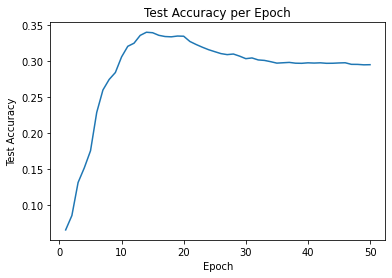

Training Accuracy: 66.87%
Test Accuracy: 29.52%
Precision: 41.43%
Recall: 34.09%
F1 Score: 34.17%
ROC AUC: 87.00%


In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and the optimizer
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initialize a list to store the accuracies
test_accuracies = []

# Training loop
model.train()
for epoch in range(50):  # assuming you want to train for 200 epochs
    optimizer.zero_grad()  # Clear gradients
    out = model(train_data.to(device))  # Perform forward pass
    loss = F.nll_loss(out, train_data.y.to(device))  # Compute the loss
    loss.backward()  # Perform backward pass
    optimizer.step()  # Update the weights

    # Switch model to evaluation mode for accuracy calculation
    model.eval()

    # Perform forward pass on your test data
    out_test = model(test_data.to(device))

    # Convert output probabilities to predicted class
    _, preds_test = torch.max(out_test, dim=1)

    # Calculate test accuracy
    correct_test = float((preds_test == test_data.y.to(device)).sum().item())
    total_test = float(test_data.y.size(0))
    accuracy_test = correct_test / total_test

    # Append the accuracy to the list
    test_accuracies.append(accuracy_test)

    # Switch model back to training mode
    model.train()

# Plot the accuracies
plt.plot(range(1, 51), test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy per Epoch')
plt.show()
# Instantiate the model and the optimizer
model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(15):  # assuming you want to train for 200 epochs
    optimizer.zero_grad()  # Clear gradients
    out = model(train_data.to(device))  # Perform forward pass
    loss = F.nll_loss(out, train_data.y.to(device))  # Compute the loss
    loss.backward()  # Perform backward pass
    optimizer.step()  # Update the weights

# Switch model to evaluation mode
model.eval()

# Perform forward pass on your training data
out_train = model(train_data.to(device))

# Convert output probabilities to predicted class
_, preds_train = torch.max(out_train, dim=1)

# Calculate training accuracy
correct_train = float((preds_train == train_data.y.to(device)).sum().item())
total_train = float(train_data.y.size(0))
accuracy_train = correct_train / total_train

# Print the training accuracy
print(f"Training Accuracy: {accuracy_train * 100:.2f}%")

# Perform forward pass on your test data
out_test = model(test_data.to(device))

# Convert output probabilities to predicted class
_, preds_test = torch.max(out_test, dim=1)

# Convert log probabilities to probabilities for test set
out_prob_test = torch.exp(out_test)

# Convert tensors to numpy arrays for use with sklearn
out_prob_test_np = out_prob_test.cpu().detach().numpy()
y_test_np = y_test_tensor.cpu().numpy()

# Compute metrics for each class and average
precision = precision_score(y_test_np, preds_test.cpu().numpy(), average='macro')
recall = recall_score(y_test_np, preds_test.cpu().numpy(), average='macro')
f1 = f1_score(y_test_np, preds_test.cpu().numpy(), average='macro')
accuracy_test = correct_test / total_test

# For AUC-ROC, we need to get the probabilities of each class
roc_auc = roc_auc_score(y_test_np, out_prob_test_np, multi_class='ovr', average='macro')

print(f"Test Accuracy: {accuracy_test * 100:.2f}%")
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1 Score: {f1*100:.2f}%')
print(f'ROC AUC: {roc_auc*100:.2f}%')

### 3.) Build a Simple Graph Convolution

- Be sure to run the GNN first as this creates the graph object we will be using.
- Wu et al. @ ICML 2019
- https://www.youtube.com/watch?v=cka4Fa4TTI4&t=513s&ab_channel=JacobHeglund

Model architecture
Input: The input to the model consists of two parts:

Node features (H(0)): An N x F matrix, where N is the number of nodes in the graph and F is the number of features per node.
Adjacency matrix (A): An N x N matrix, where Aij represents the connection between nodes i and j.
Graph Convolutional Layers: The model contains L Graph Convolutional layers, where L is the depth of the network. Each layer performs the following operation:

f(H(l-1), A) = ReLU(D(-1/2) * A * D(-1/2) * H(l-1) * W(l))

Here, D is the degree matrix of the graph, which is a diagonal matrix where Dii is the degree (number of connections) of node i. The matrix W(l) is the weight matrix for layer l.

Classification Layer: The output of the final Graph Convolutional layer is fed into a classification layer, which uses a softmax activation function to predict the class probabilities for each node.

Key features
Local Connectivity: The Graph Convolutional layers are designed to aggregate information from a node's local neighborhood, which enables the model to capture local patterns in the data.
Invariant to node order: The operations performed in the GCN model are invariant to the order of the nodes in the graph, making the model robust to different node orderings.
Scalability: The GCN model is scalable to large graphs, as the computational complexity of each layer is linear in the number of edges in the graph.
Semi-supervised learning: The model can leverage both labeled and unlabeled data during training, which is especially useful when labeled data is scarce.

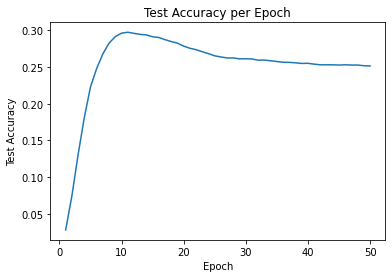

Epochs: 15
Training Accuracy: 61.07%
Test Accuracy: 25.15%
Precision: 29.74%
Recall: 29.19%
F1 Score: 29.33%
ROC AUC: 84.07%


In [77]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

edge_threshold = 0.9
epochs = 15

# Create X and y.
y = filtered_normalized_firing_rates['frame'].values
X = filtered_normalized_firing_rates.drop(columns=['frame']).values
num_classes = len(np.unique(y))

# Encode labels to class indices
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define a correlation-based edge index
corr_matrix = np.corrcoef(X, rowvar=False)

# Trim edges by edge_threshold.
edges = np.argwhere(corr_matrix > edge_threshold)

# edge_index should be a 2xN tensor where N is the number of edges, so we transpose the result
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Split the data into training and test sets
num_samples = X.shape[0]
perm = torch.randperm(num_samples)
train_perm = perm[:int(0.8 * num_samples)]  # 80% of samples for training
test_perm = perm[int(0.8 * num_samples):]  # 20% of samples for testing

X_train = X[train_perm, :]
y_train = y_encoded[train_perm]
X_test = X[test_perm, :]
y_test = y_encoded[test_perm]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create the Data objects
train_data = Data(x=X_train_tensor, y=y_train_tensor, edge_index=train_edges)
test_data = Data(x=X_test_tensor, y=y_test_tensor, edge_index=test_edges)

train_data.num_classes = num_classes
test_data.num_classes = num_classes

class SGC(torch.nn.Module):
    def __init__(self):
        super(SGC, self).__init__()
        self.conv = GCNConv(train_data.num_features, train_data.num_classes)  # assuming number of features is data.num_features

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply convolution operation
        out = self.conv(x, edge_index)

        # Output layer
        out = F.log_softmax(out, dim=1)

        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and the optimizer
model = SGC().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initialize a list to store the accuracies
test_accuracies = []

# Training loop
model.train()
for epoch in range(50):  # assuming you want to train for 200 epochs
    optimizer.zero_grad()  # Clear gradients
    out = model(train_data.to(device))  # Perform forward pass
    loss = F.nll_loss(out, train_data.y.to(device))  # Compute the loss
    loss.backward()  # Perform backward pass
    optimizer.step()  # Update the weights

    # Switch model to evaluation mode for accuracy calculation
    model.eval()

    # Perform forward pass on your test data
    out_test = model(test_data.to(device))

    # Convert output probabilities to predicted class
    _, preds_test = torch.max(out_test, dim=1)

    # Calculate test accuracy
    correct_test = float((preds_test == test_data.y.to(device)).sum().item())
    total_test = float(test_data.y.size(0))
    accuracy_test = correct_test / total_test

    # Append the accuracy to the list
    test_accuracies.append(accuracy_test)

    # Switch model back to training mode
    model.train()

# Plot the accuracies
plt.plot(range(1, 51), test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy per Epoch')
plt.show()

# Instantiate the model and the optimizer
model = SGC().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(epochs):  # assuming you want to train for 200 epochs
    optimizer.zero_grad()  # Clear gradients
    out = model(train_data.to(device))  # Perform forward pass
    loss = F.nll_loss(out, train_data.y.to(device))  # Compute the loss
    loss.backward()  # Perform backward pass
    optimizer.step()  # Update the weights

# Switch model to evaluation mode
model.eval()

# Perform forward pass on your training data
out_train = model(train_data.to(device))

# Convert output probabilities to predicted class
_, preds_train = torch.max(out_train, dim=1)

# Calculate training accuracy
correct_train = float((preds_train == train_data.y.to(device)).sum().item())
total_train = float(train_data.y.size(0))
accuracy_train = correct_train / total_train

# Print epochs evaluated at.
print(f"Epochs: {epochs}")

# Print the training accuracy
print(f"Training Accuracy: {accuracy_train * 100:.2f}%")

# Perform forward pass on your test data
out_test = model(test_data.to(device))

# Convert output probabilities to predicted class
_, preds_test = torch.max(out_test, dim=1)

# Convert log probabilities to probabilities for test set
out_prob_test = torch.exp(out_test)

# Convert tensors to numpy arrays for use with sklearn
out_prob_test_np = out_prob_test.cpu().detach().numpy()
y_test_np = y_test_tensor.cpu().numpy()

# Compute metrics for each class and average
precision = precision_score(y_test_np, preds_test.cpu().numpy(), average='macro')
recall = recall_score(y_test_np, preds_test.cpu().numpy(), average='macro')
f1 = f1_score(y_test_np, preds_test.cpu().numpy(), average='macro')
accuracy_test = correct_test / total_test

# For AUC-ROC, we need to get the probabilities of "each class
roc_auc = roc_auc_score(y_test_np, out_prob_test_np, multi_class='ovr', average='macro')

print(f"Test Accuracy: {accuracy_test * 100:.2f}%")
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1 Score: {f1*100:.2f}%')
print(f'ROC AUC: {roc_auc*100:.2f}%')

### 3.) Build a Graphsage

This is good for new networks, might be good for training on new mice. https://www.frontiersin.org/articles/10.3389/fninf.2022.1032538/full

In [78]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(train_data.num_features, 512)
        self.classifier = torch.nn.Linear(512, train_data.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First Convolutional layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)


        # Output layer
        out = F.log_softmax(self.classifier(x), dim=1)

        return out


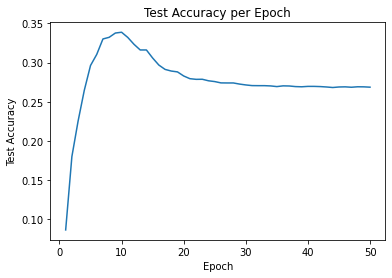

Training Accuracy: 81.17%
Test Accuracy: 26.87%
Precision: 31.88%
Recall: 30.80%
F1 Score: 30.77%
ROC AUC: 85.72%


In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model and the optimizer
model = GraphSAGE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initialize a list to store the accuracies
test_accuracies = []

# Training loop
model.train()
for epoch in range(50):  # assuming you want to train for 200 epochs
    optimizer.zero_grad()  # Clear gradients
    out = model(train_data.to(device))  # Perform forward pass
    loss = F.nll_loss(out, train_data.y.to(device))  # Compute the loss
    loss.backward()  # Perform backward pass
    optimizer.step()  # Update the weights

    # Switch model to evaluation mode for accuracy calculation
    model.eval()

    # Perform forward pass on your test data
    out_test = model(test_data.to(device))

    # Convert output probabilities to predicted class
    _, preds_test = torch.max(out_test, dim=1)

    # Calculate test accuracy
    correct_test = float((preds_test == test_data.y.to(device)).sum().item())
    total_test = float(test_data.y.size(0))
    accuracy_test = correct_test / total_test

    # Append the accuracy to the list
    test_accuracies.append(accuracy_test)

    # Switch model back to training mode
    model.train()

# Plot the accuracies
plt.plot(range(1, 51), test_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy per Epoch')
plt.show()

# Instantiate the model and the optimizer
model = GraphSAGE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(15):  # assuming you want to train for 200 epochs
    optimizer.zero_grad()  # Clear gradients
    out = model(train_data.to(device))  # Perform forward pass
    loss = F.nll_loss(out, train_data.y.to(device))  # Compute the loss
    loss.backward()  # Perform backward pass
    optimizer.step()  # Update the weights

# Switch model to evaluation mode
model.eval()

# Perform forward pass on your training data
out_train = model(train_data.to(device))

# Convert output probabilities to predicted class
_, preds_train = torch.max(out_train, dim=1)

# Calculate training accuracy
correct_train = float((preds_train == train_data.y.to(device)).sum().item())
total_train = float(train_data.y.size(0))
accuracy_train = correct_train / total_train

# Print the training accuracy
print(f"Training Accuracy: {accuracy_train * 100:.2f}%")

# Perform forward pass on your test data
out_test = model(test_data.to(device))

# Convert output probabilities to predicted class

_, preds_test = torch.max(out_test, dim=1)

# Convert log probabilities to probabilities for test set
out_prob_test = torch.exp(out_test)

# Convert tensors to numpy arrays for use with sklearn
out_prob_test_np = out_prob_test.cpu().detach().numpy()
y_test_np = y_test_tensor.cpu().numpy()

# Compute metrics for each class and average
precision = precision_score(y_test_np, preds_test.cpu().numpy(), average='macro')
recall = recall_score(y_test_np, preds_test.cpu().numpy(), average='macro')
f1 = f1_score(y_test_np, preds_test.cpu().numpy(), average='macro')
accuracy_test = correct_test / total_test

# For AUC-ROC, we need to get the probabilities of each class
roc_auc = roc_auc_score(y_test_np, out_prob_test_np, multi_class='ovr', average='macro')

print(f"Test Accuracy: {accuracy_test * 100:.2f}%")
print(f'Precision: {precision*100:.2f}%')
print(f'Recall: {recall*100:.2f}%')
print(f'F1 Score: {f1*100:.2f}%')
print(f'ROC AUC: {roc_auc*100:.2f}%')

### 3.) Build a dynamic spatio-temporal graph neural network. 

In [87]:
import os
import numpy as np
import networkx as nx
import pickle
from tqdm import tqdm
import time
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed

In [85]:
subset = filtered_normalized_firing_rates.iloc[:,:20]

# Create the directory if it doesn't exist
if not os.path.exists("graphs_721123822"):
    os.makedirs("graphs_721123822")

# Calculate correlations
correlations = np.corrcoef(subset.drop(columns=['frame']).T)

def create_graph(graph_index):
    # Create a graph for this timestep
    G = nx.Graph()
    firing_rates = subset.iloc[graph_index, 1:]
    # Add nodes
    G.add_nodes_from(subset.columns[1:])
    
    for neuron, rate in zip(subset.columns[1:], firing_rates):
        G.add_node(neuron, rate=rate)

    # Add edges
    for i, neuron1 in enumerate(subset.columns[1:]):
        for j, neuron2 in enumerate(subset.columns[1:]):
            if i != j and correlations[i, j] > 0.25:  # Only add an edge if the correlation is above 0.5
                G.add_edge(neuron1, neuron2, weight=correlations[i, j])
    
    # Add y variable as graph attribute
    G.graph['frame'] = subset.iloc[graph_index, 0]  # Assuming 'frame' is the first column

    #print(f'graph {graph_index} finished')
    return G, graph_index

def save_graph(G, graph_index):
    # Determine the folder based on the graph_index
    subfolder_name = f"graphs_721123822_{graph_index // 10000}"
    
    # Create the main directory if it doesn't exist
    main_folder = "graphs_721123822"
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    
    # Create the subdirectory inside the main directory
    folder_name = os.path.join(main_folder, subfolder_name)
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Save the graph to a file in the "graphs" directory
    with open(os.path.join(folder_name, f"graph_{graph_index}.pkl"), 'wb') as f:  # Save in pickle format
        pickle.dump(G, f)



# Define the batch size
batch_size = 200

# Calculate the number of batches
num_batches = len(subset) // batch_size + 1

# Create a ProcessPoolExecutor for graph creation and a ThreadPoolExecutor for I/O
with ProcessPoolExecutor(max_workers=2) as executor, ThreadPoolExecutor(max_workers=2) as io_executor:
    # Create a tqdm progress bar
    pbar = tqdm(total=num_batches)
    # Loop over each batch
    for batch in range(num_batches):
        # Create a list to hold the futures
        futures = []
        start_index = batch * batch_size
        end_index = min((batch + 1) * batch_size, len(subset))
        # Use the executor to submit the create_graph function for each timestep in the batch
        for i in range(start_index, end_index):
            try:
                futures.append(executor.submit(create_graph, i))
            except Exception as e:
                print(f"Error creating graph {i}: {e}")
        # Wait for all futures to complete for this batch
        for future in as_completed(futures):
            # Use the io_executor to submit the save_graph function
            try:
                G, i = future.result()
                io_executor.submit(save_graph, G, i)
            except Exception as e:
                print(f"Error saving graph {i}: {e}")
        # Update the progress bar
        pbar.update(1)
    # Close the progress bar
    pbar.close()

100%|██████████| 298/298 [00:22<00:00, 12.96it/s]


In [88]:
# Create the directory if it doesn't exist
if not os.path.exists("graphs_721123822"):
    os.makedirs("graphs_721123822")

# Calculate correlations
correlations = np.corrcoef(filtered_normalized_firing_rates.drop(columns=['frame']).T)

def create_graph(graph_index):
    # Create a graph for this timestep
    G = nx.Graph()
    firing_rates = filtered_normalized_firing_rates.iloc[graph_index, 1:]
    # Add nodes
    G.add_nodes_from(filtered_normalized_firing_rates.columns[1:])
    
    for neuron, rate in zip(filtered_normalized_firing_rates.columns[1:], firing_rates):
        G.add_node(neuron, rate=rate)

    # Add edges
    for i, neuron1 in enumerate(filtered_normalized_firing_rates.columns[1:]):
        for j, neuron2 in enumerate(filtered_normalized_firing_rates.columns[1:]):
            if i != j and correlations[i, j] > 0.25:  # Only add an edge if the correlation is above 0.5
                G.add_edge(neuron1, neuron2, weight=correlations[i, j])
    
    # Add y variable as graph attribute
    G.graph['frame'] = filtered_normalized_firing_rates.iloc[graph_index, 0]  # Assuming 'frame' is the first column

    #print(f'graph {graph_index} finished')
    return G, graph_index

def save_graph(G, graph_index):
    # Determine the folder based on the graph_index
    subfolder_name = f"graphs_721123822_{graph_index // 10000}"
    
    # Create the main directory if it doesn't exist
    main_folder = "graphs_721123822"
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    
    # Create the subdirectory inside the main directory
    folder_name = os.path.join(main_folder, subfolder_name)
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Save the graph to a file in the "graphs" directory
    with open(os.path.join(folder_name, f"graph_{graph_index}.pkl"), 'wb') as f:  # Save in pickle format
        pickle.dump(G, f)



# Define the batch size
batch_size = 200

# Calculate the number of batches
num_batches = len(filtered_normalized_firing_rates) // batch_size + 1

# Create a ProcessPoolExecutor for graph creation and a ThreadPoolExecutor for I/O
with ProcessPoolExecutor(max_workers=2) as executor, ThreadPoolExecutor(max_workers=2) as io_executor:
    # Create a tqdm progress bar
    pbar = tqdm(total=num_batches)
    # Loop over each batch
    for batch in range(num_batches):
        # Create a list to hold the futures
        futures = []
        start_index = batch * batch_size
        end_index = min((batch + 1) * batch_size, len(filtered_normalized_firing_rates))
        # Use the executor to submit the create_graph function for each timestep in the batch
        for i in range(start_index, end_index):
            try:
                futures.append(executor.submit(create_graph, i))
            except Exception as e:
                print(f"Error creating graph {i}: {e}")
        # Wait for all futures to complete for this batch
        for future in as_completed(futures):
            # Use the io_executor to submit the save_graph function
            try:
                G, i = future.result()
                io_executor.submit(save_graph, G, i)
            except Exception as e:
                print(f"Error saving graph {i}: {e}")
        # Update the progress bar
        pbar.update(1)
    # Close the progress bar
    pbar.close()

  1%|          | 3/298 [01:47<2:56:30, 35.90s/it]

KeyboardInterrupt: 

In [ ]:
import os

def count_pickle_files(folder_path):
    # Initialize the count of pickle files
    count = 0

    # Walk through the directory tree
    for dirpath, dirnames, filenames in os.walk(folder_path):
        # Filter the files to include only pickle files
        pickle_files = [file for file in filenames if file.endswith('.pkl')]

        # Add the count of pickle files in this directory to the total count
        count += len(pickle_files)

    # Print the count of pickle files
    print(f"Number of pickle files: {count}")

# Provide the folder path
folder_path = 'graphs_721123822'

# Call the function to count pickle files
count_pickle_files(folder_path)

In [ ]:
import networkx as nx
import pickle

# Load the graph from a pickle file
with open("graphs_721123822/graph_0.pkl", "rb") as f:
    G = pickle.load(f)

# Print the number of nodes and edges in the graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Print the frame attribute of the graph
print(f"Frame: {G.graph['frame']}")

# Compute the degree of each node (returns a DegreeView object)
degrees = G.degree()

# Convert DegreeView to a list of tuples and print
degree_list = list(degrees)
print(f"Degrees: {degree_list}")

# Compute the average degree of the graph
average_degree = sum(deg for node, deg in degree_list) / len(degree_list)
print(f"Average degree: {average_degree}")

# Compute the density of the graph
density = nx.density(G)
print(f"Density: {density}")

# Compute the diameter of the graph (note: this requires the graph to be connected)
if nx.is_connected(G):
    diameter = nx.diameter(G)
    print(f"Diameter: {diameter}")
else:
    print("Graph is not connected, cannot compute diameter.")

### 3.) Build the STGNN

In [9]:
import os

def count_pickle_files(folder_path):
    # Get the list of files in the folder
    files = os.listdir(folder_path)

    # Filter the files to include only pickle files
    pickle_files = [file for file in files if file.endswith('.pkl')]

    # Print the count of pickle files
    print(f"Number of pickle files: {len(pickle_files)}")

# Provide the folder path
folder_path = 'graphs_721123822'

# Call the function to count pickle files
count_pickle_files(folder_path)

Number of pickle files: 21600


In [2]:
import torch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch.nn import Conv1d
from tqdm import tqdm

class STGNN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(STGNN, self).__init__()
        self.spatial_conv = GCNConv(node_features, hidden_channels)
        self.temporal_conv = Conv1d(1, hidden_channels, kernel_size=3, padding=1)
        self.classifier = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.spatial_conv(x, edge_index)
        x = x.relu()
        x = x.unsqueeze(1)  # Add a dummy channel dimension
        x = self.temporal_conv(x).squeeze(0)
        x = x.relu()
        x = global_mean_pool(x, batch)
        x = self.classifier(x)
        return x

def extract_features(graphs):
    node_features = []
    for G in graphs:
        for node in G.nodes:
            node_features.append([G.nodes[node]['rate']])  # Wrap 'rate' in a list to create a 2D list
    return node_features

# Get the list of all pickle files in your directory
all_files = os.listdir("graphs_721123822")

# Filter out the files that are not pickle files
pickle_files = [file for file in all_files if file.endswith(".pkl")]

total_graphs = 16789  # Update this to the total number of graphs you have

# Calculate the number of training and test graphs
num_train_graphs = int(total_graphs * 0.8)
num_test_graphs = total_graphs - num_train_graphs


node_features = 64  # replace with the actual number of node features
num_classes = 119  # replace with the actual number of classes
num_node_features = 1  # Update this to match the actual number of node features in your graph data
model = STGNN(node_features=num_node_features, hidden_channels=64, num_classes=num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
'''
# Load all graphs into a list
graphs = []
for i in range(total_graphs):
    with open(os.path.join("graphs_721123822", f"graph_{i}.pkl"), 'rb') as f:
        G = pickle.load(f)
    graphs.append(G)
 '''   
def train():
    model.train()
    train_loader = tqdm(range(num_train_graphs), desc="Training", unit="graph")
    for i in train_loader:
        G = graphs[i] 
        node_features = extract_features([G])
        node_features = torch.tensor(node_features, dtype=torch.float)

        # Create a label tensor where all elements are the same
        label = torch.full((node_features.size(0),), y[i])

        node_mapping = {node: i for i, node in enumerate(G.nodes)}
        edge_index = torch.tensor([(node_mapping[edge[0]], node_mapping[edge[1]]) for edge in G.edges]).t().contiguous()
        data = Data(x=node_features, edge_index=edge_index, y=label)

        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)


def test():
    model.eval()
    correct = 0  # Initialize 'correct'
    total_nodes = 0  # Initialize 'total_nodes'
    for i in range(num_train_graphs, num_train_graphs + num_test_graphs):

        G = graphs[i] 
        node_features = extract_features([G])
        node_features = torch.tensor(node_features, dtype=torch.float)
        label = y[i]  # Get the corresponding label from your y array
        label = torch.tensor([y[i]])  # Get the corresponding label from your y array

        # Create a mapping from the original node labels to integers starting from 0
        node_mapping = {node: i for i, node in enumerate(G.nodes)}
        # Use the mapping to relabel the nodes when creating the edge_index tensor
        edge_index = torch.tensor([(node_mapping[edge[0]], node_mapping[edge[1]]) for edge in G.edges]).t().contiguous()

        data = Data(x=node_features, edge_index=edge_index, y=label)
        data.y = label

        out = model(data)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
        total_nodes += data.num_nodes  # Add the number of nodes in the current graph to the total
        del G  # Delete the graph to free up memory
    return correct / total_nodes  # Use total_nodes as the denominator



for epoch in range(1, 101):
    train()
    test_acc = test()
    print(f'Test accuracy: {test_acc * 100:.2f}%')

Training:   0%|          | 0/13431 [00:00<?, ?graph/s]


NameError: name 'graphs' is not defined

In [ ]:
import torch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch.nn import Conv1d, Conv2d
from torch.nn.utils import weight_norm

class Chomp1d(torch.nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(torch.nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(Conv1d(n_inputs, n_outputs, kernel_size,
                                         stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(dropout)

        self.net = torch.nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1)
        self.downsample = Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = torch.nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(torch.nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class STGNN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, num_classes):
        super(STGNN, self).__init__()
        self.spatial_conv = GCNConv(node_features, hidden_channels)
        self.temporal_conv = TemporalConvNet(1, [hidden_channels]*3)  # 3 layers of TCN
        self.classifier = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.spatial_conv(x, edge_index)
        x = x.relu()
        x = x.unsqueeze(1)  # Add a dummy channel dimension
        x = self.temporal_conv(x)
        x = x.squeeze(0)
        x = x.relu()
        x = global_mean_pool(x, batch)
        x = self.classifier(x)
        return x


def extract_features(graphs):
    node_features = []
    for G in graphs:
        for node in G.nodes:
            node_features.append([G.nodes[node]['rate']])  # Wrap 'rate' in a list to create a 2D list
    return node_features

# Get the list of all pickle files in your directory
all_files = os.listdir("graphs_721123822")

# Filter out the files that are not pickle files
pickle_files = [file for file in all_files if file.endswith(".pkl")]

total_graphs = 16789  # Update this to the total number of graphs you have

# Calculate the number of training and test graphs
num_train_graphs = int(total_graphs * 0.8)
num_test_graphs = total_graphs - num_train_graphs


node_features = 64  # replace with the actual number of node features
num_classes = 119  # replace with the actual number of classes
num_node_features = 1  # Update this to match the actual number of node features in your graph data
model = STGNN(node_features=num_node_features, hidden_channels=64, num_classes=num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Load all graphs into a list
graphs = []
for i in range(total_graphs):
    with open(os.path.join("graphs_721123822", f"graph_{i}.pkl"), 'rb') as f:
        G = pickle.load(f)
    graphs.append(G)
 
def train():
    model.train()
    train_loader = tqdm(range(num_train_graphs), desc="Training", unit="graph")
    for i in train_loader:
        G = graphs[i] 
        node_features = extract_features([G])
        node_features = torch.tensor(node_features, dtype=torch.float)

        # Create a label tensor where all elements are the same
        label = torch.full((node_features.size(0),), y[i])

        node_mapping = {node: i for i, node in enumerate(G.nodes)}
        edge_index = torch.tensor([(node_mapping[edge[0]], node_mapping[edge[1]]) for edge in G.edges]).t().contiguous()
        data = Data(x=node_features, edge_index=edge_index, y=label)

        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)


def test():
    model.eval()
    correct = 0  # Initialize 'correct'
    total_nodes = 0  # Initialize 'total_nodes'
    for i in range(num_train_graphs, num_train_graphs + num_test_graphs):

        G = graphs[i] 
        node_features = extract_features([G])
        node_features = torch.tensor(node_features, dtype=torch.float)
        label = y[i]  # Get the corresponding label from your y array
        label = torch.tensor([y[i]])  # Get the corresponding label from your y array

        # Create a mapping from the original node labels to integers starting from 0
        node_mapping = {node: i for i, node in enumerate(G.nodes)}
        # Use the mapping to relabel the nodes when creating the edge_index tensor
        edge_index = torch.tensor([(node_mapping[edge[0]], node_mapping[edge[1]]) for edge in G.edges]).t().contiguous()

        data = Data(x=node_features, edge_index=edge_index, y=label)
        data.y = label

        out = model(data)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
        total_nodes += data.num_nodes  # Add the number of nodes in the current graph to the total
        del G  # Delete the graph to free up memory
    return correct / total_nodes  # Use total_nodes as the denominator



for epoch in range(1, 101):
    train()
    test_acc = test()
    print(f'Test accuracy: {test_acc * 100:.2f}%')

### 3.) Visualize graphs.

/nas/longleaf/home/rayrayc/.local/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


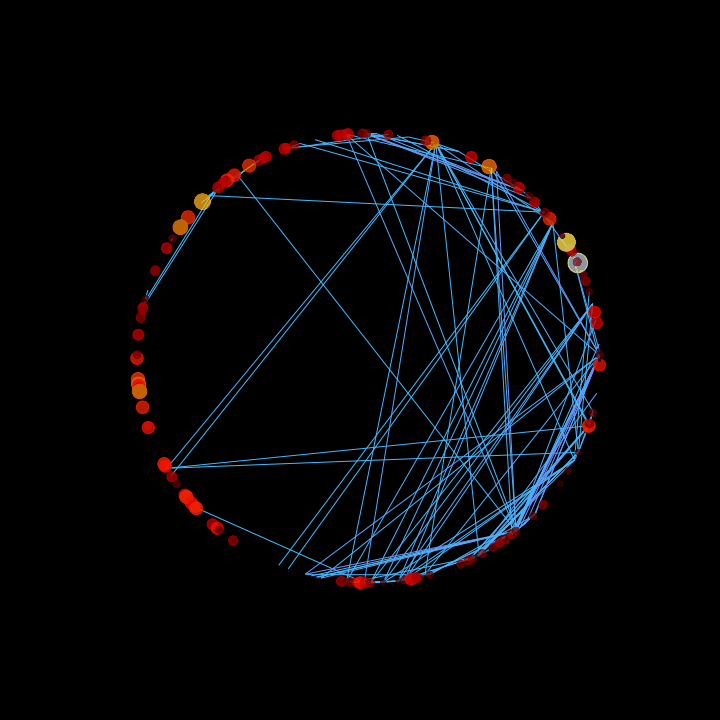

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [3]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import os
import pickle
from IPython.display import Image, display

# List to store the file paths of the images
image_file_paths = []

for i in range(10):
    # Load the graph
    with open(os.path.join("graphs_721123822", f"graph_{i}.pkl"), 'rb') as f:
        G = pickle.load(f)

    # Create a new figure
    plt.figure(figsize=(10, 10))

    # Get firing rates
    rates = {n: d['rate'] for n, d in G.nodes(data=True)}

    # Map firing rates to node sizes (you can adjust the scaling factor as needed)
    node_sizes = [50 * rate for rate in rates.values()]

    # Normalize firing rates to the range 0 to 1 for color mapping
    max_rate = max(rates.values())
    normalized_rates = [rate / max_rate for rate in rates.values()]

    # Map normalized firing rates to colors using a color map
    node_colors = [cm.hot(rate) for rate in normalized_rates]

    # Create a list of edges to remove
    edges_to_remove = [(u, v) for u, v in G.edges() if rates[u] <= 0 and rates[v] <= 0]

    # Remove the edges
    G.remove_edges_from(edges_to_remove)

    # Get edge weights
    edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]

    # Map edge weights to colors using a color map
    edge_colors = [cm.cool(weight) for weight in edge_weights]

    # Draw the graph
    plt.gca().set_facecolor('black')
    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=1)

    # Save the figure to a file
    image_file_path = f"graph_{i}.png"
    plt.savefig(image_file_path, facecolor='black')
    image_file_paths.append(image_file_path)

    # Clear the figure so that the next graph is not drawn on top of this one
    plt.clf()

# Sort the image file paths numerically based on the index value
image_file_paths.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

# Create a GIF
with imageio.get_writer('graph_sequence.gif', mode='I', loop=0) as writer:
    for image_file_path in image_file_paths:
        image = imageio.imread(image_file_path)
        writer.append_data(image)

# Display the GIF
display(Image(filename='graph_sequence.gif'))


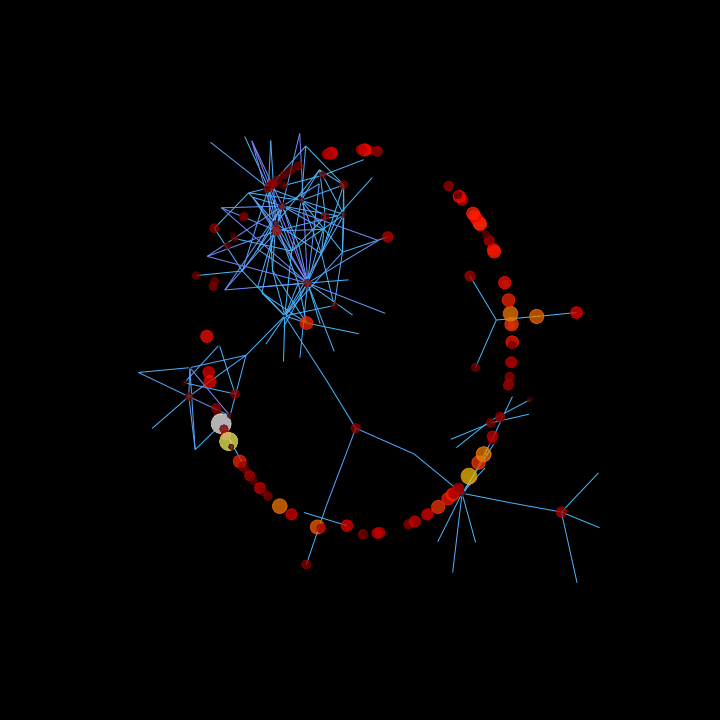

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [4]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import os
import pickle
from IPython.display import Image, display

# List to store the file paths of the images
image_file_paths = []

for i in range(10):
    # Load the graph
    with open(os.path.join("graphs_721123822", f"graph_{i}.pkl"), 'rb') as f:
        G = pickle.load(f)

    # Create a new figure
    plt.figure(figsize=(10, 10))

    # Get firing rates
    rates = {n: d['rate'] for n, d in G.nodes(data=True)}

    # Map firing rates to node sizes (you can adjust the scaling factor as needed)
    node_sizes = [50 * rate for rate in rates.values()]

    # Normalize firing rates to the range 0 to 1 for color mapping
    max_rate = max(rates.values())
    normalized_rates = [rate / max_rate for rate in rates.values()]

    # Map normalized firing rates to colors using a color map
    node_colors = [cm.hot(rate) for rate in normalized_rates]

    # Create a list of edges to remove
    edges_to_remove = [(u, v) for u, v in G.edges() if rates[u] <= 0 and rates[v] <= 0]

    # Remove the edges
    G.remove_edges_from(edges_to_remove)

    # Get edge weights
    edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]

    # Map edge weights to colors using a color map
    edge_colors = [cm.cool(weight) for weight in edge_weights]

    # Draw the graph
    plt.gca().set_facecolor('black')
    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=1)

    # Save the figure to a file
    image_file_path = f"graph_{i}.png"
    plt.savefig(image_file_path, facecolor='black')
    image_file_paths.append(image_file_path)

    # Clear the figure so that the next graph is not drawn on top of this one
    plt.clf()

# Sort the image file paths numerically based on the index value
image_file_paths.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

# Create a GIF
with imageio.get_writer('graph_sequence.gif', mode='I', loop=0) as writer:
    for image_file_path in image_file_paths:
        image = imageio.imread(image_file_path)
        writer.append_data(image)

# Display the GIF
display(Image(filename='graph_sequence.gif'))


/tmp/ipykernel_2096344/1776200273.py:65: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_file_path)


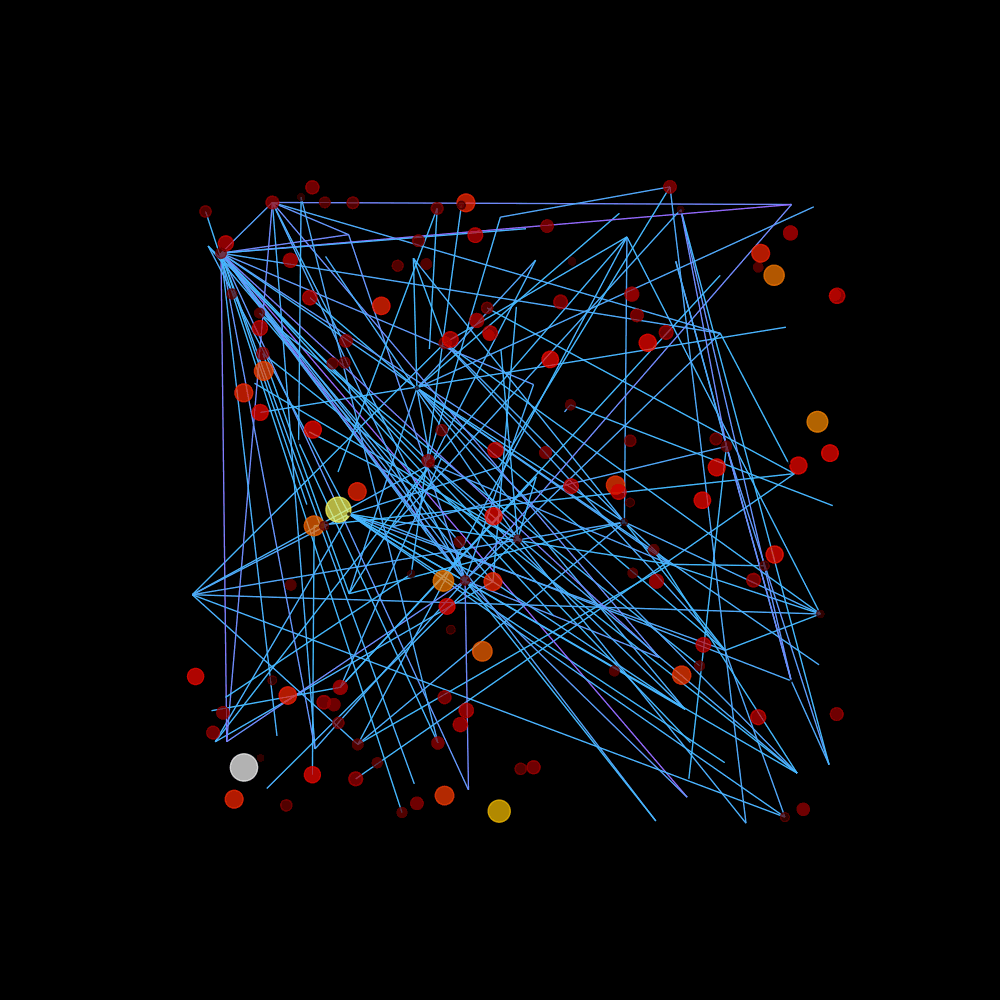

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [103]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import os
import pickle
from IPython.display import Image, display

# List to store the file paths of the images
image_file_paths = []

for i in range(10):
    # Load the graph
    with open(os.path.join("graphs_721123822", f"graph_{i}.pkl"), 'rb') as f:
        G = pickle.load(f)

    # Create a new figure
    plt.figure(figsize=(10, 10))

    # Get firing rates
    rates = {n: d['rate'] for n, d in G.nodes(data=True)}

    # Map firing rates to node sizes (you can adjust the scaling factor as needed)
    node_sizes = [50 * rate for rate in rates.values()]

    # Normalize firing rates to the range 0 to 1 for color mapping
    max_rate = max(rates.values())
    normalized_rates = [rate / max_rate for rate in rates.values()]

    # Map normalized firing rates to colors using a color map
    node_colors = [cm.hot(rate) for rate in normalized_rates]

    # Create a list of edges to remove
    edges_to_remove = [(u, v) for u, v in G.edges() if rates[u] <= 0 and rates[v] <= 0]

    # Remove the edges
    G.remove_edges_from(edges_to_remove)

    # Get edge weights
    edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]

    # Map edge weights to colors using a color map
    edge_colors = [cm.cool(weight) for weight in edge_weights]

    # Draw the graph
    plt.gca().set_facecolor('black')
    pos = nx.random_layout(G, seed = 69)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=1)

    # Save the figure to a file
    image_file_path = f"graph_{i}.png"
    plt.savefig(image_file_path, facecolor='black')
    image_file_paths.append(image_file_path)

    # Clear the figure so that the next graph is not drawn on top of this one
    plt.clf()

# Sort the image file paths numerically based on the index value
image_file_paths.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

# Create a GIF
with imageio.get_writer('graph_sequence.gif', mode='I', loop=0) as writer:
    for image_file_path in image_file_paths:
        image = imageio.imread(image_file_path)
        writer.append_data(image)

# Display the GIF
display(Image(filename='graph_sequence.gif'))


<a name="references"></a>
# References 
[Go to Outline](#outline)

- neuropixel data overview: Large-scale neural recordings with single neuron resolution using Neuropixels probes in human cortex,https://www.nature.com/articles/s41593-021-00997-0, referenced in opening 

- more neuropixel data overview: Fully integrated silicon probes for high-density recording of neural activity, https://www.nature.com/articles/nature24636, referenced in opening.

- synaptic transmission: https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/synaptic-transmission, referenced in opening.

- Data white paper: Allen Brain Observatory – Neuropixels Visual Coding, https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/80/75/8075a100-ca64-429a-b39a-569121b612b2/neuropixels_visual_coding_-_white_paper_v10.pdf

- LSTM: Paper model overview: http://www.bioinf.jku.at/publications/older/2604.pdf \
    -Another Paper: https://proceedings.neurips.cc/paper_files/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf \
    -Explanation - This guy worked at the stats dept at UNC I believe. https://www.youtube.com/watch?v=YCzL96nL7j0&ab_channel=StatQuestwithJoshStarmer \
    -step by step: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Static Spatio-Temporal GNN: https://www.youtube.com/watch?v=WEWq93tioC4&ab_channel=DeepFindr \
    -https://arxiv.org/pdf/2006.10637.pdf \
    -https://arxiv.org/pdf/2104.07788.pdf \
    -https://arxiv.org/abs/2301.10569
- Dynamic Spatio-Temporal GNN: https://arxiv.org/pdf/2006.10637.pdf \
    -model: https://drive.google.com/file/d/1WpBOZlDiDTTeeXN1gr31TMCWeh4qWW7W/view
    
- Contribution of behavioural variability to representational drift by Yaniv Ziv: https://elifesciences.org/articles/77907#sa1. This paper discusses how the variability of modulatory mechanisms can contribute to representational changes. The author analyzed large-scale recording of neural activity from the Allen Brain Observatory and found that behavioural variability significantly contributes to representational changes.

- Generating model for GNN: Discovering Symbolic Models from Deep Learning with Inductive Biases - https://www.youtube.com/watch?v=LMb5tvW-UoQ&ab_channel=YannicKilcher
    -paper: https://arxiv.org/abs/2006.11287
    -Code: https://github.com/MilesCranmer/symbolic_deep_learning
- Graph-Tool:https://graph-tool.skewed.de/static/doc/index.html

-High-dimensional geometry of population responses in visual cortex: https://www.nature.com/articles/s41586-019-1346-5
        - Shows similar images may invoke similar responses to save on personal computation.

-Physics Informed Neural Net(PINN): https://arxiv.org/abs/2201.05624
        -Similar to Discovering Symbolic Models from Deep Learning with Inductive Biases: https://www.youtube.com/watch?v=LMb5tvW-UoQ&t=1217s&ab_channel=YannicKilcher
        -Converting NNs to symbolic models "https://www.youtube.com/watch?v=wmQIcTOzH0k&ab_channel=MilesCranmer"

- STGNN model examples/variations.
        - A deep graph neural network architecture for modelling spatio-temporal dynamics in resting-state functional MRI data: https://www.sciencedirect.com/science/article/pii/S1361841522001189
        - STGCN: A spatial–temporal graph deep learning model for urban flood nowcasting leveraging heterogeneous community features; https://www.nature.com/articles/s41598-023-32548-x
        - scalable STGNN: https://arxiv.org/abs/2209.06520

- Current Functional connectomics. Systematic Integration of Structural and Functional Data into Multi-Scale Models of Mouse Primary Visual Cortex: https://www.biorxiv.org/content/10.1101/662189v2.full
        - Identifying Functional Connectivity in Large-Scale Neural Ensemble Recordings: A Multiscale Data Mining Approach: https://direct.mit.edu/neco/article-abstract/21/2/450/8696/Identifying-Functional-Connectivity-in-Large-Scale?redirectedFrom=fulltext
        - Learning-Induced Enduring Changes in Functional Connectivity among Prefrontal Cortical Neurons: https://www.jneurosci.org/content/27/4/909
- new functional connectivity studies : Distinct brain-wide presynaptic networks underlie the functional identity of individual cortical neurons : https://www.biorxiv.org/content/10.1101/2023.05.25.542329v1
- Using GNN to show changes in functional connectivity : https://www.frontiersin.org/articles/10.3389/fninf.2022.1032538/full
            - The above paper shows that showing the funcitonal connectivity in a GNN using graphsage is useful for predicting drug changes in functional connectivit.
            - They used umap in python!
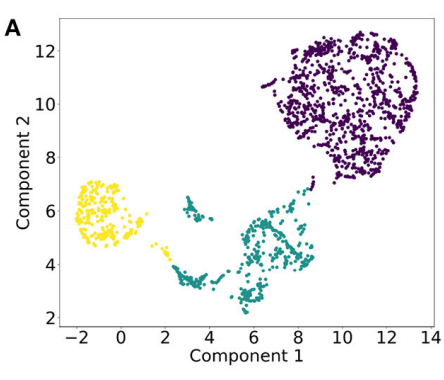
            - Neuropixel competitor(produces same type of data) https://pubmed.ncbi.nlm.nih.gov/25973786/